# Libraries import
In this notebook we'll explore one simple benchmark model and a statistical model, more advanced but still to be considered as baseline

In [1]:
# Import necessary libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Configure visualization settings
sns.set_context("notebook", font_scale=1.5)

# Load the dataset
file_path = 'C:/Users/pc/Desktop/politecnico/b-FINTECH/business cases/Fintech_BC/BC4/data/Dataset4_EWS.xlsx'
#file_path = './data/Dataset4_EWS.xlsx'

## Real-World dataset

From Bloomberg, consisting of weekly observations of:

- Market and macroeconomic indicators (e.g., indices, rates).
- A response variable `Y` indicating **anomalous periods** (e.g., market stress events).

In [2]:
# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Load the data from the Excel file
# First sheet contains market data with dates and anomaly labels, second sheet contains metadata
data_df = pd.read_excel(file_path, sheet_name='Markets')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Check the structure of the loaded data
print("Data columns:", data_df.columns.tolist())

# Extract date and anomaly label columns
date_col = 'Date' if 'Date' in data_df.columns else data_df.columns[0]
y_col = 'Y' if 'Y' in data_df.columns else None

# Convert dates to datetime format
data_df[date_col] = pd.to_datetime(data_df[date_col], dayfirst=True)  # Date format is dd/mm/yy

# Set date as index
data_df = data_df.set_index(date_col)

# Extract features (all columns except Y if it exists)
if y_col:
    X_df = data_df.drop(y_col, axis=1)
    y = data_df[y_col].values
else:
    X_df = data_df
    y = None

# Display basic information about the dataset
print(f"Data shape: {X_df.shape}")
print(f"Total number of records: {len(X_df)}")
print(f"Response variable length: {len(y)}")
print(f"Time period: from {X_df.index.min().strftime('%m/%d/%Y')} to {X_df.index.max().strftime('%m/%d/%Y')}")
print(f"Frequency: {pd.infer_freq(X_df.index) or 'Weekly'}")
print(f"Number of variables: {X_df.shape[1]}")
if y_col:
    print(f"Number of anomalies: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")

# Create a more comprehensive metadata table with additional statistics
enhanced_metadata = []

# Determine the correct column names for ticker and description
ticker_col = 'ticker' if 'ticker' in metadata_df.columns else metadata_df.columns[0]
desc_col = 'description' if 'description' in metadata_df.columns else metadata_df.columns[1] if len(metadata_df.columns) > 1 else ticker_col

for ticker in X_df.columns:
    # Get metadata for this ticker if available
    meta_row = metadata_df[metadata_df[ticker_col] == ticker] if ticker in metadata_df[ticker_col].values else pd.DataFrame()

    # Get description or use ticker if not found
    description = meta_row[desc_col].values[0] if not meta_row.empty and desc_col in meta_row.columns else ticker

    # Calculate statistics for this series
    series = X_df[ticker]

    enhanced_metadata.append({
        'Ticker': ticker,
        'Description': description,
        'Mean': series.mean(),
        'Std.Dev': series.std(),
        'Min': series.min(),
        'Max': series.max(),
        'Missing values': series.isna().sum(),
        'Missing (%)': f"{series.isna().mean()*100:.2f}%"
    })

# Create enhanced metadata dataframe
enhanced_meta_df = pd.DataFrame(enhanced_metadata)

# Display the enhanced metadata
print("\nMetadata and statistics:")
display(enhanced_meta_df)


Data columns: ['Data', 'BDIY', 'CRY', 'Cl1', 'DXY', 'ECSURPUS', 'EMUSTRUU', 'EONIA', 'GBP', 'GT10', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y', 'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR', 'JPY', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU', 'MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS', 'US0001M', 'USGG2YR', 'USGG30YR', 'USGG3M', 'VIX', 'XAUBGNL', 'Y']
Data shape: (1111, 42)
Total number of records: 1111
Response variable length: 1111
Time period: from 01/11/2000 to 04/20/2021
Frequency: W-TUE
Number of variables: 42
Number of anomalies: 237 (21.33%)

Metadata and statistics:


,Ticker,Description,Mean,Std.Dev,Min,Max,Missing values,Missing (%)
0,BDIY,Baltic Dry Index,2259.860486,2017.811888,291.00000,11793.00000,0,0.00%
1,CRY,TR/CC CRB ER Index,245.247649,68.278081,106.29290,467.57000,0,0.00%
2,Cl1,Generic 1st 'CL' Future,60.708101,25.900813,10.01000,140.97000,0,0.00%
3,DXY,DOLLAR INDEX SPOT,90.934982,11.379095,71.32900,119.82000,0,0.00%
4,ECSURPUS,Bloomberg ECO US Surprise Inde,0.036153,0.349453,-0.97400,0.99100,0,0.00%
5,EMUSTRUU,EM USD Aggregate,704.379495,309.951768,230.52670,1286.35300,0,0.00%
6,EONIA,EMMI EURO OverNight Index Aver,1.363676,1.721894,-0.49800,5.73000,0,0.00%
7,GBP,British Pound Spot,1.569618,0.212340,1.17230,2.08520,0,0.00%
8,GT10,US TREASURY N/B,3.266748,1.332464,0.50800,6.74800,0,0.00%
9,GTDEM10Y,BUNDESREPUB. DEUTSCHLAND,2.448365,1.851558,-0.79400,5.64400,0,0.00%


# No Brain Benchmark Model - Explanation

## Overview
A simple baseline model that predicts anomalies based on consecutive past anomalies.

## Core Logic
- **Prediction rule**:  
  - Predict `1` (anomaly) if the previous `N` consecutive values were all `1` , here with `N = 4`
  - Otherwise predict `0` (normal)

## Parameters
| Parameter | Type | Description | Default |
|-----------|------|-------------|---------|
| `y` | array-like | Binary input (0=normal, 1=anomaly) | - |
| `lookback_window` | int | Consecutive anomalies needed to trigger prediction | 4 |

## How It Works
1. Initializes a zero-filled prediction array
2. For each time step starting from index `N`:
   - Checks the previous `N` values
   - Sets prediction to `1` if all `N` previous values were `1`
3. Returns the prediction array

## Example
**Input**:  
`[0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]`

**Output**:  
`[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]`

## Use Cases
- Baseline for anomaly detection models
- Simple benchmark for comparison
- Requires no training

In [3]:
# No Brain Benchmark Model implementation
def create_no_brain_predictions(y, lookback_window=4):
    """
    No Brain benchmark model: predicts anomaly (1) in the next week 
    if there were 4 consecutive anomalies in the previous weeks.
    
    Parameters:
    -----------
    y : array-like
        Binary target array (0 = normal, 1 = anomaly)
    lookback_window : int
        Number of consecutive anomalies to look for (default: 4)
    
    Returns:
    --------
    predictions : np.array
        Binary predictions for each time step
    """
    
    predictions = np.zeros(len(y))
    
    # Start from the lookback window index since we need previous observations
    for i in range(lookback_window, len(y)):
        # Check if the previous 'lookback_window' observations are all anomalies (1)
        previous_window = y[i-lookback_window:i]
        
        # If all previous observations in the window are anomalies, predict anomaly
        if np.all(previous_window == 1):
            predictions[i] = 1
    
    return predictions

# Model Evaluation Framework - Explanation

## Overview
Here below a comprehensive evaluation system for the model above with three main components:

### 1. Core Evaluation Function (`evaluate_model`)
**Metrics Calculated:**
- **Accuracy**: Overall correct prediction rate
- **Precision**: Correct anomaly predictions / Total anomaly predictions  
- **Recall**: Correct anomaly predictions / Actual anomalies  
- **F1-Score**: Harmonic mean of precision and recall
- **Confusion Matrix**: Detailed breakdown of prediction types

**Output Format:**
```python
{
    'accuracy': 0.95,
    'precision': 0.82,
    'recall': 0.75,
    'f1_score': 0.78,
    'confusion_matrix': array([[850, 20],
                             [15, 115]])
}

Applying No Brain Benchmark Model...

No Brain Benchmark - Performance Metrics:
Accuracy:  0.8722
Precision: 0.8626
Recall:    0.4768
F1-Score:  0.6141

Confusion Matrix:
Predicted →
Actual ↓
         Normal  Anomaly
Normal      856       18
Anomaly     124      113


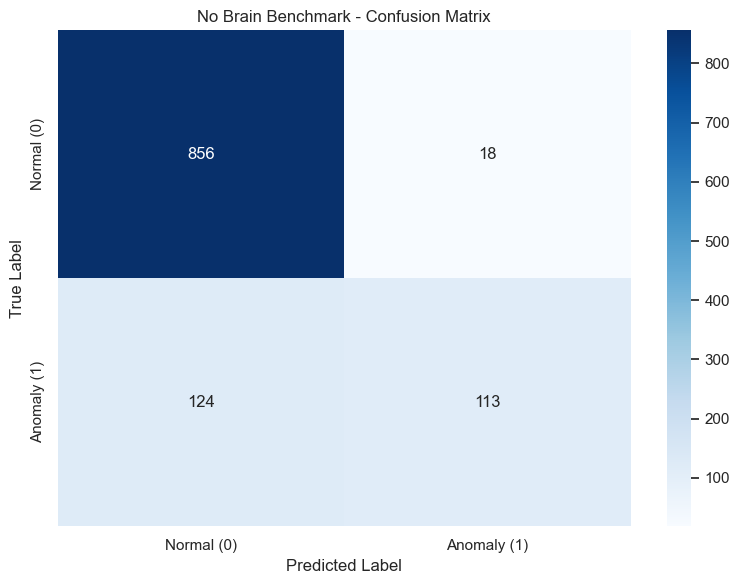


Detailed Analysis:
Total samples: 1111
Actual anomalies: 237 (21.33%)
Predicted anomalies: 131 (11.79%)

Prediction breakdown:
True Positives:  113
False Positives: 18
True Negatives:  856
False Negatives: 124

Sample predictions:

Model Performance Summary:
   Metric  Value
 Accuracy 0.8722
Precision 0.8626
   Recall 0.4768
 F1-Score 0.6141


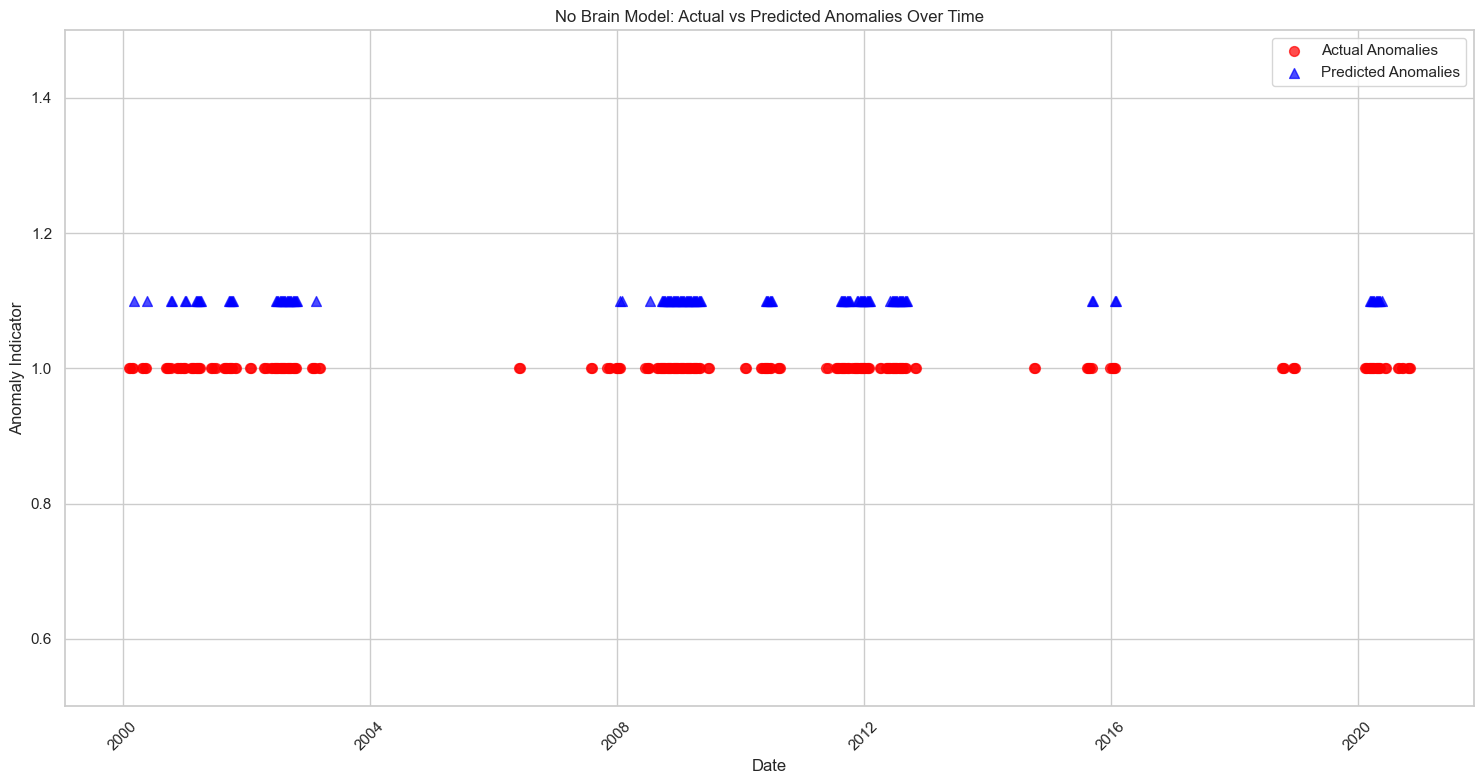


No Brain Benchmark Model Analysis Complete!


In [4]:
# Evaluate the No Brain model using various metrics
def evaluate_model(y_true, y_pred, model_name="No Brain Model"):
    """
    Calculate and display comprehensive evaluation metrics
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted binary labels
    model_name : str
        Name of the model for display purposes
    
    Returns:
    --------
    metrics : dict
        Dictionary containing all calculated metrics
    """
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Store metrics in dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }
    
    # Print results
    print(f"\n{model_name} - Performance Metrics:")
    print("=" * 50)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    print(f"\nConfusion Matrix:")
    print("Predicted →")
    print("Actual ↓")
    print(f"         Normal  Anomaly")
    print(f"Normal   {cm[0,0]:6d}  {cm[0,1]:7d}")
    print(f"Anomaly  {cm[1,0]:6d}  {cm[1,1]:7d}")
    
    return metrics

def plot_confusion_matrix(cm, model_name="No Brain Model"):
    """
    Plot confusion matrix as a heatmap
    
    Parameters:
    -----------
    cm : array-like
        Confusion matrix
    model_name : str
        Name of the model for the plot title
    """
    
    plt.figure(figsize=(8, 6))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal (0)', 'Anomaly (1)'],
                yticklabels=['Normal (0)', 'Anomaly (1)'])
    
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

def analyze_prediction_patterns(y_true, y_pred, dates=None):
    """
    Analyze prediction patterns and show detailed statistics
    
    Parameters:
    -----------
    y_true : array-like
        True binary labels
    y_pred : array-like
        Predicted binary labels  
    dates : array-like, optional
        Date index for the data
    """
    
    print(f"\nDetailed Analysis:")
    print("=" * 50)
    
    # Basic counts
    total_samples = len(y_true)
    actual_anomalies = np.sum(y_true == 1)
    predicted_anomalies = np.sum(y_pred == 1)
    
    print(f"Total samples: {total_samples}")
    print(f"Actual anomalies: {actual_anomalies} ({actual_anomalies/total_samples*100:.2f}%)")
    print(f"Predicted anomalies: {predicted_anomalies} ({predicted_anomalies/total_samples*100:.2f}%)")
    
    # True/False Positives and Negatives
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    print(f"\nPrediction breakdown:")
    print(f"True Positives:  {tp}")
    print(f"False Positives: {fp}")
    print(f"True Negatives:  {tn}")
    print(f"False Negatives: {fn}")
    
    # Show some examples of predictions if dates are available
    if dates is not None:
        print(f"\nSample predictions:")
        df_results = pd.DataFrame({
            'Date': dates,
            'Actual': y_true,
            'Predicted': y_pred
        })
        

# Apply the No Brain model to your data
print("Applying No Brain Benchmark Model...")
print("=" * 60)

# Create predictions using the no brain model
no_brain_predictions = create_no_brain_predictions(y, lookback_window=4)

# Evaluate the model
metrics = evaluate_model(y, no_brain_predictions, "No Brain Benchmark")

# Plot confusion matrix
plot_confusion_matrix(metrics['confusion_matrix'], "No Brain Benchmark")

# Detailed analysis
if 'X_df' in locals() and hasattr(X_df, 'index'):
    analyze_prediction_patterns(y, no_brain_predictions, X_df.index)
else:
    analyze_prediction_patterns(y, no_brain_predictions)

# Create a results summary
results_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]
})

print(f"\nModel Performance Summary:")
print("=" * 30)
print(results_summary.to_string(index=False, float_format='%.4f'))

# Optional: Create a time series plot showing actual vs predicted
if 'X_df' in locals() and hasattr(X_df, 'index'):
    plt.figure(figsize=(15, 8))
    
    # Plot actual anomalies
    anomaly_dates = X_df.index[y == 1]
    plt.scatter(anomaly_dates, np.ones(len(anomaly_dates)), 
               color='red', alpha=0.7, s=50, label='Actual Anomalies')
    
    # Plot predicted anomalies
    predicted_dates = X_df.index[no_brain_predictions == 1]
    plt.scatter(predicted_dates, np.ones(len(predicted_dates)) + 0.1, 
               color='blue', alpha=0.7, s=50, marker='^', label='Predicted Anomalies')
    
    plt.ylim(0.5, 1.5)
    plt.xlabel('Date')
    plt.ylabel('Anomaly Indicator')
    plt.title('No Brain Model: Actual vs Predicted Anomalies Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print(f"\n" + "="*60)
print("No Brain Benchmark Model Analysis Complete!")
print("="*60)

## MVG majority voting model

In this other baseline model, we apply the **Multivariate Gaussian** statistical model to each stationarized macroeconomic group of features, the **final prediction** is achieved through majority voting.

The first thing we do is to group the features by macroeconomic category: **Equities, Bonds, Interest rates, Commodities, Currencies** and the economic indicator, ie the 
**Economic surprise index** left as is.

In [5]:
#Group the features
# Define lists of variables by type
# Commodities
commodities = [col for col in X_df.columns if col in ['XAUBGNL', 'CRY', 'Cl1','BDIY']]

# Currencies
currencies = [col for col in X_df.columns if col in ['DXY', 'GBP', 'JPY']]

# Bond Indices
bond_indices = [col for col in X_df.columns if col in ['EMUSTRUU', 'LF94TRUU', 'LF98TRUU', 'LG30TRUU', 'LMBITR', 'LP01TREU', 'LUACTRUU', 'LUMSTRUU']]

# Equity Indices
equity_indices = [col for col in X_df.columns if col in ['MXBR', 'MXCN', 'MXEU', 'MXIN', 'MXJP', 'MXRU', 'MXUS']]

# Volatility Index
volatility_index = [col for col in X_df.columns if col in ['VIX']]

# Interest Rates / Sovereign Yields
interest_rates = [col for col in X_df.columns if col in [
    'EONIA', 'GTDEM10Y', 'GTDEM2Y', 'GTDEM30Y', 'GTGBP20Y', 'GTGBP2Y', 'GTGBP30Y',
    'GTITL10YR', 'GTITL2YR', 'GTITL30YR', 'GTJPY10YR', 'GTJPY2YR', 'GTJPY30YR',
    'US0001M', 'USGG3M', 'USGG2YR', 'GT10', 'USGG30YR'
]]

# Economic Indicator
economic_surprise = [col for col in X_df.columns if col in ['ECSURPUS']]

The next step is to transform the data, in particular the goal is to perform a **feature selection** within the most numerous groups (Bond, Interest rates, Equity) through the **kernel PCA**. 
- We keep the maximum between: 3 principal components or >80% cumulative explained variance. 
- In this way we have a clear, synthetic, interpretable signal for each category, this allows us to easily handle each category.

<br>


Processing group: EQ
Selected 3 components for Eq (explaining 70.49% of variance).

Processing group: BOND
Selected 2 components for Bond (explaining 81.41% of variance).

Processing group: IR
Selected 3 components for IR (explaining 69.71% of variance).

Shape of Equity KPCA: (1111, 3)
Shape of Bond KPCA: (1111, 2)
Shape of Interest Rates KPCA: (1111, 3)


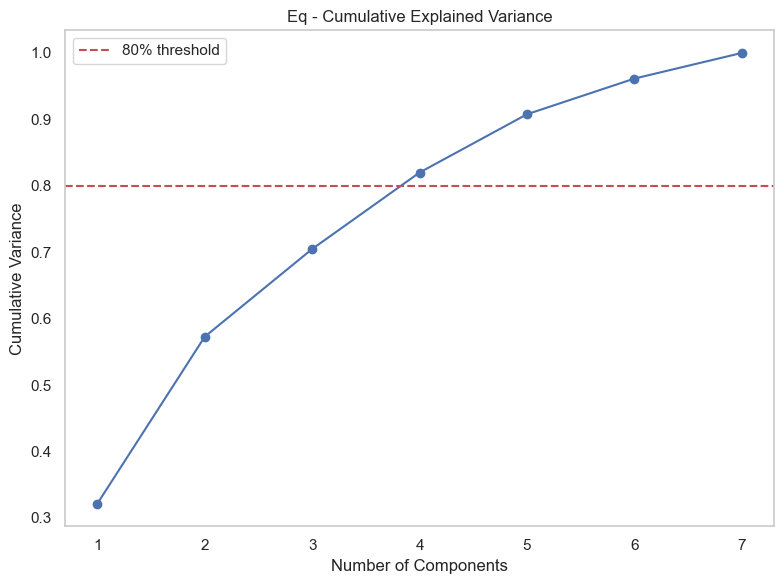

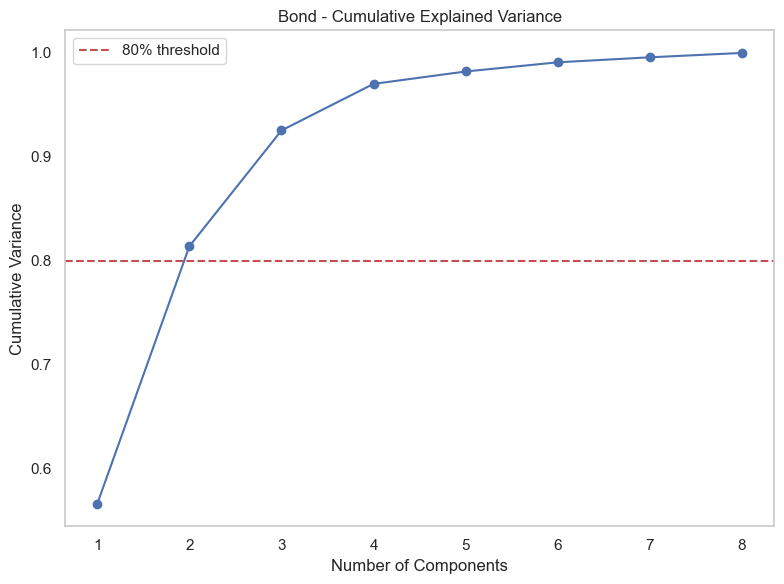

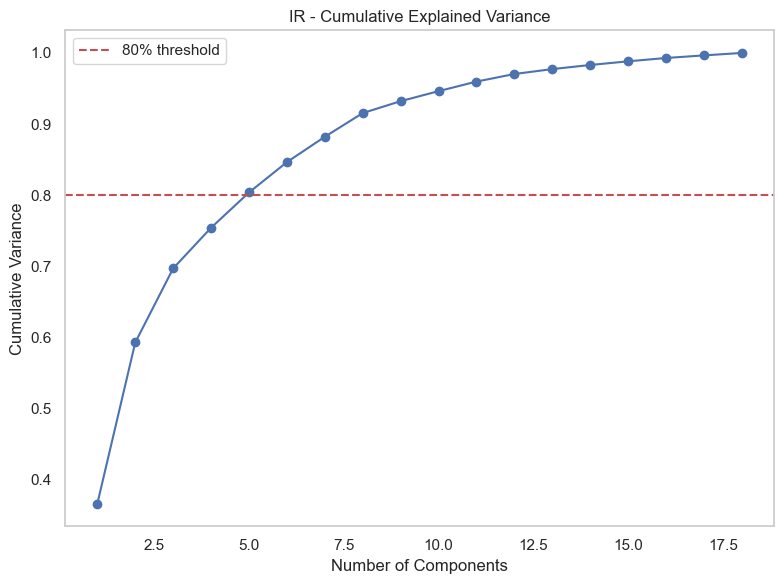

In [6]:
#Kernel PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

# Groups
groups = {
    'Eq': equity_indices,
    'Bond': bond_indices,
    'IR': interest_rates
}

# Initialize dictionaries
kernel_pca_features = {}
explained_variances = {}

# Loop through each group
for group_abbr, group_columns in groups.items():
    print(f"\nProcessing group: {group_abbr.upper()}")
    
    # Subset the data
    X_group = X_df[group_columns].dropna()
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_group)
    
    # Apply Kernel PCA
    kpca = KernelPCA(kernel='rbf', fit_inverse_transform=False, n_components=len(group_columns))
    X_kpca = kpca.fit_transform(X_scaled)
    
    # Calculate approximate explained variance ratio
    lambdas = np.var(X_kpca, axis=0)
    explained_variance_ratio = lambdas / np.sum(lambdas)
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Save explained variance for plotting
    explained_variances[group_abbr] = cumulative_variance
    
    # Determine number of components (max 3 or enough for >80% variance)
    n_components_selected = np.searchsorted(cumulative_variance, 0.8) + 1
    n_components_selected = min(n_components_selected, 3)
    
    print(f"Selected {n_components_selected} components for {group_abbr} (explaining {cumulative_variance[n_components_selected-1]*100:.2f}% of variance).")
    
    # Keep only selected components
    X_kpca_reduced = X_kpca[:, :n_components_selected]
    
    # Create a DataFrame with proper names like Eq_PC1, Eq_PC2, etc.
    component_names = [f"{group_abbr}_PC{i+1}" for i in range(n_components_selected)]
    kernel_pca_features[group_abbr] = pd.DataFrame(X_kpca_reduced, 
                                                    index=X_group.index,
                                                    columns=component_names)

# Now you have a separate dataframe for each group
Eq_kpca = kernel_pca_features['Eq']
Bond_kpca = kernel_pca_features['Bond']
IR_kpca = kernel_pca_features['IR']

# Example prints
print("\nShape of Equity KPCA:", Eq_kpca.shape)
print("Shape of Bond KPCA:", Bond_kpca.shape)
print("Shape of Interest Rates KPCA:", IR_kpca.shape)

# Plot explained variance for each group
for group_abbr, cumvar in explained_variances.items():
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    plt.plot(np.arange(1, len(cumvar)+1), cumvar, marker='o')
    plt.axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
    plt.title(f'{group_abbr} - Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Stationarity Transformation

In this model we decided to work with **stationary** data.This means that the **joint distribution** of the features (or their principal components) must be stable over time.

The rationale is intuitive:

- We want to use historical data to infer patterns related to systemic risk.
- If the underlying structure shifts over time, any model based on past behavior becomes unreliable.

---

## Coping with stationarity

As we expected, the principal components of the Equity indices can be negative, we clearly can't apply log-differences to it. We **modify approach** by first stationarizing
all the raw time series per group, in this way:

- **Interest rates and yields**: first differences (they can be negative or close to zero).
- **Economic surprise index**: left as is (already roughly stationary).
- **All the rest**: log-differenced (they are strictly positive).

**Then** we apply the kernel PCA as done before, but now to the stationary time series, then we check AGAIN for stationarity through the Augmented Dickey-Fuller test and if it fails needed we differentiate also the selected principal components.

<br>

Processing Eq


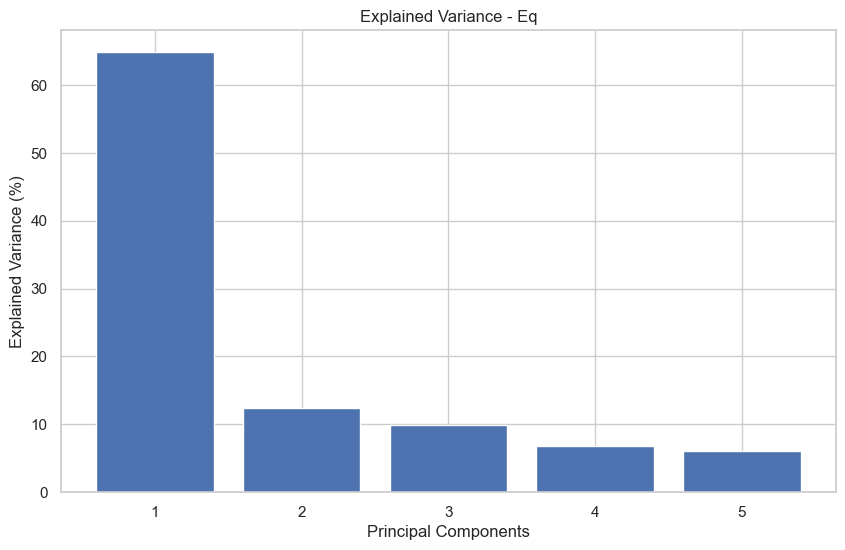

Selected 3 components for Eq (cumulative explained variance: 0.87)
Eq_PC1 is stationary (p-value=0.0000).
Eq_PC2 is stationary (p-value=0.0000).
Eq_PC3 is stationary (p-value=0.0000).
Processing Bond


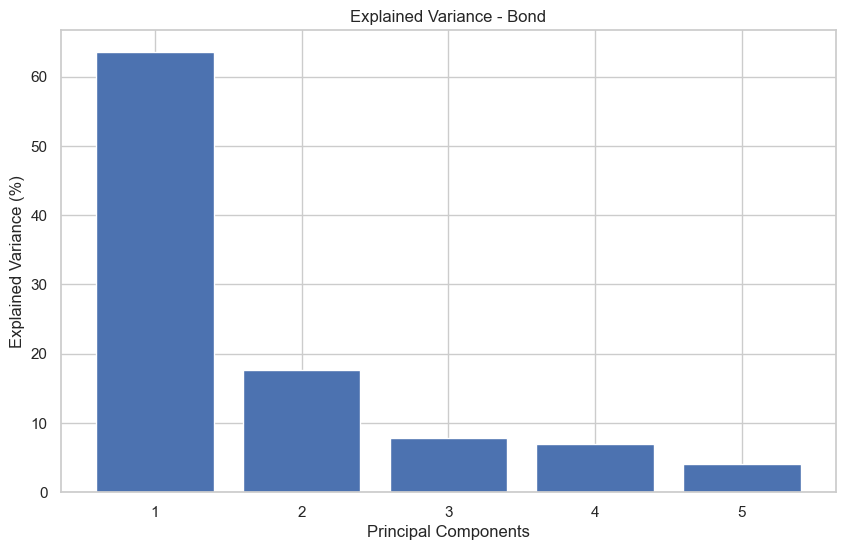

Selected 2 components for Bond (cumulative explained variance: 0.81)
Bond_PC1 is stationary (p-value=0.0000).
Bond_PC2 is stationary (p-value=0.0000).
Processing IR


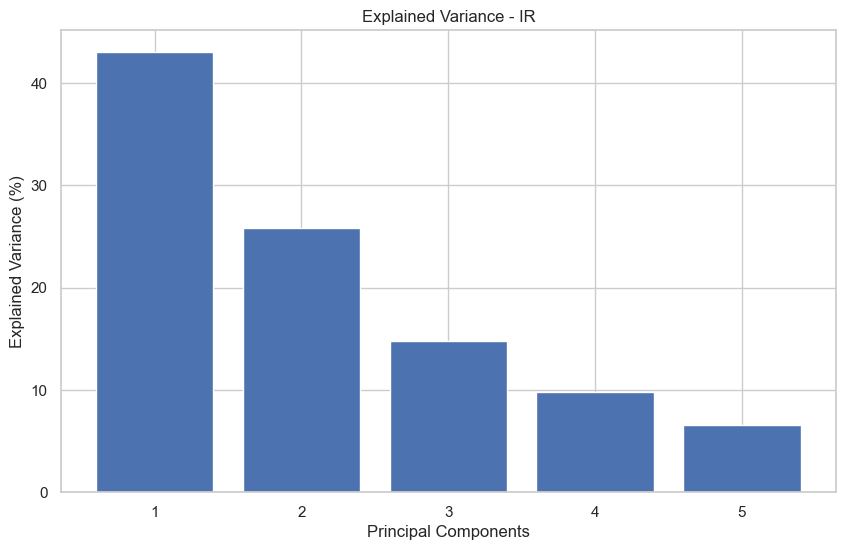

Selected 3 components for IR (cumulative explained variance: 0.84)
IR_PC1 is stationary (p-value=0.0000).
IR_PC2 is stationary (p-value=0.0000).
IR_PC3 is stationary (p-value=0.0000).


In [7]:
from statsmodels.tsa.stattools import adfuller

# --- Create stationary version of each group ---

def log_diff(series):
    return np.diff(np.log(series))

def first_diff(series):
    return np.diff(series)

def identity(series):
    return series[1:]  # just to align lengths

# Empty dictionaries to hold stationary data
stationary_data = {}

# Apply transformations
groups = {
    'commodities': commodities,
    'currencies': currencies,
    'bond_indices': bond_indices,
    'equity_indices': equity_indices,
    'volatility_index': volatility_index,
    'interest_rates': interest_rates,
    'economic_surprise': economic_surprise
}

for group_name, variables in groups.items():
    transformed = pd.DataFrame(index=X_df.index[1:])  # After diff/logdiff we lose one row
    for var in variables:
        if var in X_df.columns:
            if group_name == 'interest_rates':
                transformed[var] = first_diff(X_df[var])
            elif group_name == 'economic_surprise':
                transformed[var] = identity(X_df[var])
            else:
                transformed[var] = log_diff(X_df[var])
    stationary_data[group_name] = transformed

# Now we have stationary versions:
# stationary_data['commodities'], stationary_data['currencies'], etc.

# --- Apply Kernel PCA to specific groups (equity, bond, interest rate) ---

def apply_kpca_and_check_stationarity(df_group, group_label, kernel='rbf', gamma=0.1):
    print(f"Processing {group_label}")
    
    # Apply Kernel PCA
    kpca = KernelPCA(n_components=min(5, df_group.shape[1]), kernel=kernel, gamma=gamma, fit_inverse_transform=False)
    components = kpca.fit_transform(df_group)
    
    # Explained variance via eigenvalues (approximation since KPCA doesn't return explained variance directly)
    eigenvalues = np.var(components, axis=0)
    explained_var_ratio = eigenvalues / np.sum(eigenvalues)
    
    # Plot explained variance
    plt.figure()
    plt.bar(range(1, len(explained_var_ratio)+1), explained_var_ratio*100)
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance (%)')
    plt.title(f'Explained Variance - {group_label}')
    plt.show()

    # Select number of components such that explained variance >80% or max 3 components
    cum_var = np.cumsum(explained_var_ratio)
    n_components_selected = min(3, np.searchsorted(cum_var, 0.8) + 1)

    print(f"Selected {n_components_selected} components for {group_label} (cumulative explained variance: {cum_var[n_components_selected-1]:.2f})")
    
    selected_components = components[:, :n_components_selected]

    # Build a DataFrame with proper names
    component_names = [f"{group_label}_PC{i+1}" for i in range(n_components_selected)]
    kpca_df = pd.DataFrame(selected_components, index=df_group.index, columns=component_names)

    # Check stationarity and difference if necessary
    final_df = pd.DataFrame(index=kpca_df.index)  # Lose one more row if differencing
    for col in kpca_df.columns:
        adf_test = adfuller(kpca_df[col])
        p_value = adf_test[1]
        if p_value > 0.05:
            print(f"{col} is non-stationary (p-value={p_value:.4f}), applying first difference.")
            final_df[col] = np.diff(kpca_df[col])
        else:
            print(f"{col} is stationary (p-value={p_value:.4f}).")
            final_df[col] = kpca_df[col]  # align index
        
    return final_df

# Apply the function
Eq_kpca = apply_kpca_and_check_stationarity(stationary_data['equity_indices'], 'Eq')
Bond_kpca = apply_kpca_and_check_stationarity(stationary_data['bond_indices'], 'Bond')
IR_kpca = apply_kpca_and_check_stationarity(stationary_data['interest_rates'], 'IR')

# Now Eq_kpca, Bond_kpca and IR_kpca are ready and stationary 🎯

## MVG-based anomaly detector with supervised threshold tuning

- The kernel-PCA applied to the stationarize features yielded **stationary principal components** as can be seen from the p-values of the ADF tests
- Now we are ready to apply our **Multivariate Gaussian anomaly detector**  to our **stationary and condensed** dataset.

We follow the same steps as with synthetic data for each group, we'll have 7 different models and exploit majority voting for final predictions:

1. Fit the distribution of normal data.
2. Score all points using the estimated PDF.
3. Tune the threshold $\varepsilon$ on a labeled validation set.
4. Evaluate on a hold-out test set.

<br>

Let's start with **reshuffling and splitting** our data.

<br>

In [8]:
# Adjust the response variable to match the new data length
if y is not None:
    y_stationary = y[1:]
else:
    y_stationary = None

# Check shapes of each group to verify time series lengths
print("Checking shapes of each data group:")
print("-" * 50)

# Original data
print(f"Original X_df shape: {X_df.shape}")
print()

# Check shapes of original grouped data
print("Original grouped data:")
for group_name, variables in groups.items():
    # Count only columns that exist in X_df
    valid_vars = [var for var in variables if var in X_df.columns]
    print(f"  {group_name}: {len(valid_vars)} variables")
print()

# Check shapes of stationary data
print("Stationary transformed data:")
for group_name, df in stationary_data.items():
    print(f"  {group_name}: {df.shape} (rows, columns)")
print()

# Check shape of response variable results
print(f"Response variable Y shape: {y_stationary.shape} (rows, columns)")
print()

# Check shapes of PCA results
print("KPCA transformed data:")
print(f"  Equity indices (Eq_kpca): {Eq_kpca.shape} (rows, columns)")
print(f"  Bond indices (Bond_kpca): {Bond_kpca.shape} (rows, columns)")
print(f"  Interest rates (IR_kpca): {IR_kpca.shape} (rows, columns)")
print()

# Check for row alignment by comparing indices
print("Checking index alignment:")
stationary_keys = list(stationary_data.keys())
if len(stationary_keys) > 1:
    first_index = stationary_data[stationary_keys[0]].index
    for group_name in stationary_keys[1:]:
        current_index = stationary_data[group_name].index
        is_aligned = first_index.equals(current_index)
        print(f"  {stationary_keys[0]} and {group_name} indices aligned: {is_aligned}")

# Check if PCA results have aligned indices
if hasattr(Eq_kpca, 'index') and hasattr(Bond_kpca, 'index') and hasattr(IR_kpca, 'index'):
    print("  Eq_kpca and Bond_kpca indices aligned:", Eq_kpca.index.equals(Bond_kpca.index))
    print("  Eq_kpca and IR_kpca indices aligned:", Eq_kpca.index.equals(IR_kpca.index))
    print("  Bond_kpca and IR_kpca indices aligned:", Bond_kpca.index.equals(IR_kpca.index))

Checking shapes of each data group:
--------------------------------------------------
Original X_df shape: (1111, 42)

Original grouped data:
  commodities: 4 variables
  currencies: 3 variables
  bond_indices: 8 variables
  equity_indices: 7 variables
  volatility_index: 1 variables
  interest_rates: 18 variables
  economic_surprise: 1 variables

Stationary transformed data:
  commodities: (1110, 4) (rows, columns)
  currencies: (1110, 3) (rows, columns)
  bond_indices: (1110, 8) (rows, columns)
  equity_indices: (1110, 7) (rows, columns)
  volatility_index: (1110, 1) (rows, columns)
  interest_rates: (1110, 18) (rows, columns)
  economic_surprise: (1110, 1) (rows, columns)

Response variable Y shape: (1110,) (rows, columns)

KPCA transformed data:
  Equity indices (Eq_kpca): (1110, 3) (rows, columns)
  Bond indices (Bond_kpca): (1110, 2) (rows, columns)
  Interest rates (IR_kpca): (1110, 3) (rows, columns)

Checking index alignment:
  commodities and currencies indices aligned: True

In [9]:
# Adjust the response variable to match the new data length
if y is not None:
    y_stationary = y[1:]
else:
    y_stationary = None

# Check shapes of each group to verify time series lengths
print("Checking shapes of each data group:")
print("-" * 50)

# Original data
print(f"Original X_df shape: {X_df.shape}")
print()

# Check shapes of original grouped data
print("Original grouped data:")
for group_name, variables in groups.items():
    # Count only columns that exist in X_df
    valid_vars = [var for var in variables if var in X_df.columns]
    print(f"  {group_name}: {len(valid_vars)} variables")
print()

# Check shapes of stationary data
print("Stationary transformed data:")
for group_name, df in stationary_data.items():
    print(f"  {group_name}: {df.shape} (rows, columns)")
print()

# Check shape of response variable results
print(f"Response variable Y shape: {y_stationary.shape} (rows, columns)")
print()

# Check shapes of PCA results
print("KPCA transformed data:")
print(f"  Equity indices (Eq_kpca): {Eq_kpca.shape} (rows, columns)")
print(f"  Bond indices (Bond_kpca): {Bond_kpca.shape} (rows, columns)")
print(f"  Interest rates (IR_kpca): {IR_kpca.shape} (rows, columns)")
print()

# Check for row alignment by comparing indices
print("Checking index alignment:")
stationary_keys = list(stationary_data.keys())
if len(stationary_keys) > 1:
    first_index = stationary_data[stationary_keys[0]].index
    for group_name in stationary_keys[1:]:
        current_index = stationary_data[group_name].index
        is_aligned = first_index.equals(current_index)
        print(f"  {stationary_keys[0]} and {group_name} indices aligned: {is_aligned}")

# Check if PCA results have aligned indices
if hasattr(Eq_kpca, 'index') and hasattr(Bond_kpca, 'index') and hasattr(IR_kpca, 'index'):
    print("  Eq_kpca and Bond_kpca indices aligned:", Eq_kpca.index.equals(Bond_kpca.index))
    print("  Eq_kpca and IR_kpca indices aligned:", Eq_kpca.index.equals(IR_kpca.index))
    print("  Bond_kpca and IR_kpca indices aligned:", Bond_kpca.index.equals(IR_kpca.index))

Checking shapes of each data group:
--------------------------------------------------
Original X_df shape: (1111, 42)

Original grouped data:
  commodities: 4 variables
  currencies: 3 variables
  bond_indices: 8 variables
  equity_indices: 7 variables
  volatility_index: 1 variables
  interest_rates: 18 variables
  economic_surprise: 1 variables

Stationary transformed data:
  commodities: (1110, 4) (rows, columns)
  currencies: (1110, 3) (rows, columns)
  bond_indices: (1110, 8) (rows, columns)
  equity_indices: (1110, 7) (rows, columns)
  volatility_index: (1110, 1) (rows, columns)
  interest_rates: (1110, 18) (rows, columns)
  economic_surprise: (1110, 1) (rows, columns)

Response variable Y shape: (1110,) (rows, columns)

KPCA transformed data:
  Equity indices (Eq_kpca): (1110, 3) (rows, columns)
  Bond indices (Bond_kpca): (1110, 2) (rows, columns)
  Interest rates (IR_kpca): (1110, 3) (rows, columns)

Checking index alignment:
  commodities and currencies indices aligned: True

### MVG Detection with Majority Voting - Summary

For **each group** (commodities, currencies, equity indices, bond indices, volatility index, interest rates, economic surprise):

1. **Data Preparation**:
   - Shuffle data to break autocorrelation
   - Split into training (80% normal), cross-validation (10% normal + 50% anomalies), and test sets (10% normal + 50% anomalies)
   - Standardize features using StandardScaler

2. **Model Training**:
   - Estimate parameters (μ, Σ) of multivariate Gaussian distribution from training data
   - For univariate cases (1 feature), calculate mean and variance
   - For multivariate cases, calculate mean vector and covariance matrix

3. **Threshold Selection**:
   - Calculate probability densities for cross-validation set
   - Search for optimal epsilon (threshold) that maximizes accuracy
   - Track F1, precision, and recall during search

4. **Evaluation**:
   - Apply model with best epsilon to test set
   - Calculate accuracy, precision, recall, F1
   - Generate confusion matrix

5. **Visualizations for Each Group**:
   - **Metrics vs Epsilon**: Plot showing accuracy, F1, precision, recall across epsilon values (log scale)
   - **Confusion Matrix**: Heatmap showing TP, FP, TN, FN on test set

**Majority Voting**:
- Combine predictions from all groups
- Final prediction = anomaly if majority (>50%) of models predict anomaly
- Generate overall confusion matrix and metrics

**Final Visualizations**:
- **Accuracy Comparison**: Horizontal bar plot showing each model's accuracy vs majority voting
- **F1 Score Comparison**: Horizontal bar plot comparing F1 scores
- **Model Agreement Matrix**: Heatmap showing pairwise agreement between models' predictions

Starting Multivariate Gaussian Anomaly Detection with Majority Voting

Response variable Y shape: (1110,)

Processing group: commodities
Total examples: 1110
Normal examples: 873
Anomalous examples: 237
Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)

--- Processing commodities Group ---
Mean vector shape: (4,)
Covariance matrix shape: (4, 4)
Best Accuracy on CV set: 0.6537
Best Epsilon: 1.61503563e-02
Corresponding F1 score: 0.7102
Corresponding Precision: 0.6850
Corresponding Recall: 0.7373


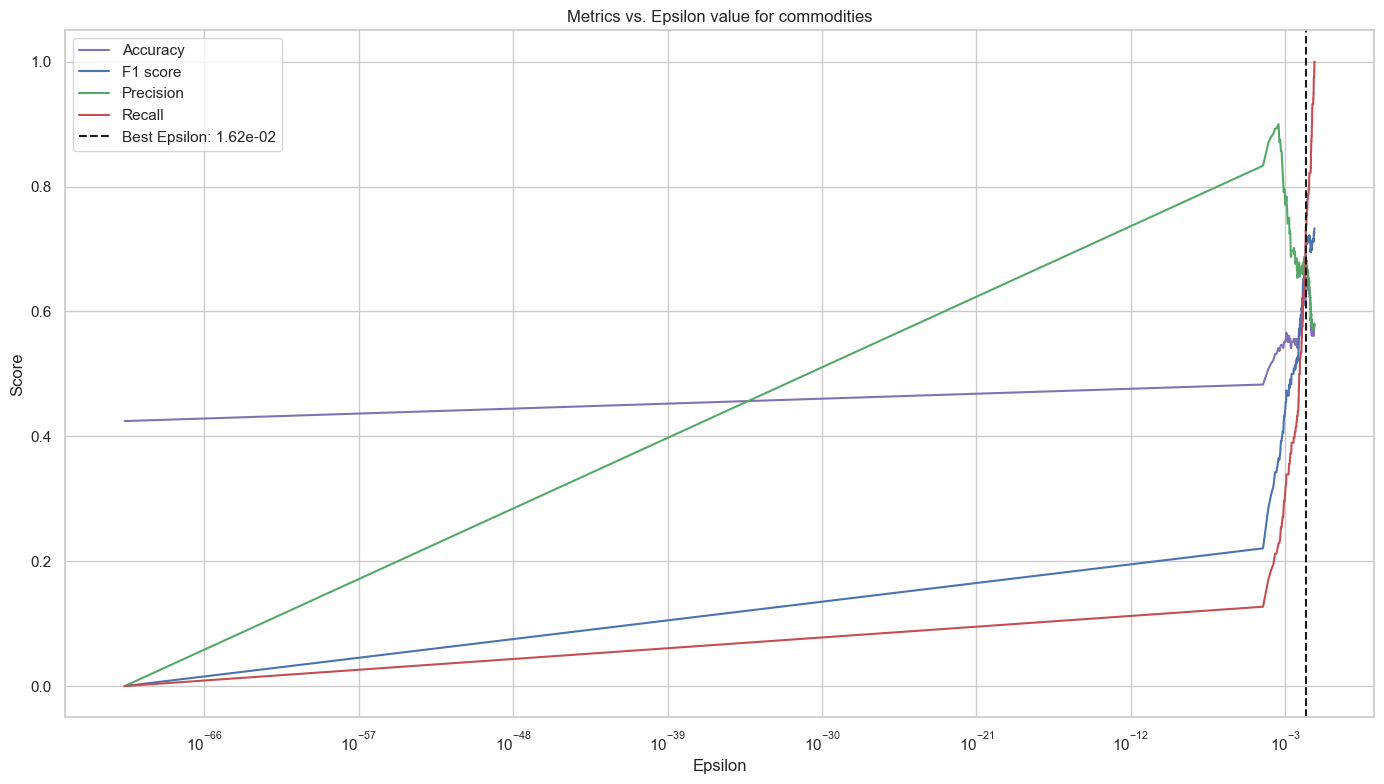


Test set performance for commodities:
Accuracy: 0.5507
Precision: 0.5942
Recall: 0.6891
F1 Score: 0.6381

Confusion Matrix:
True Negatives: 32
False Positives: 56
False Negatives: 37
True Positives: 82


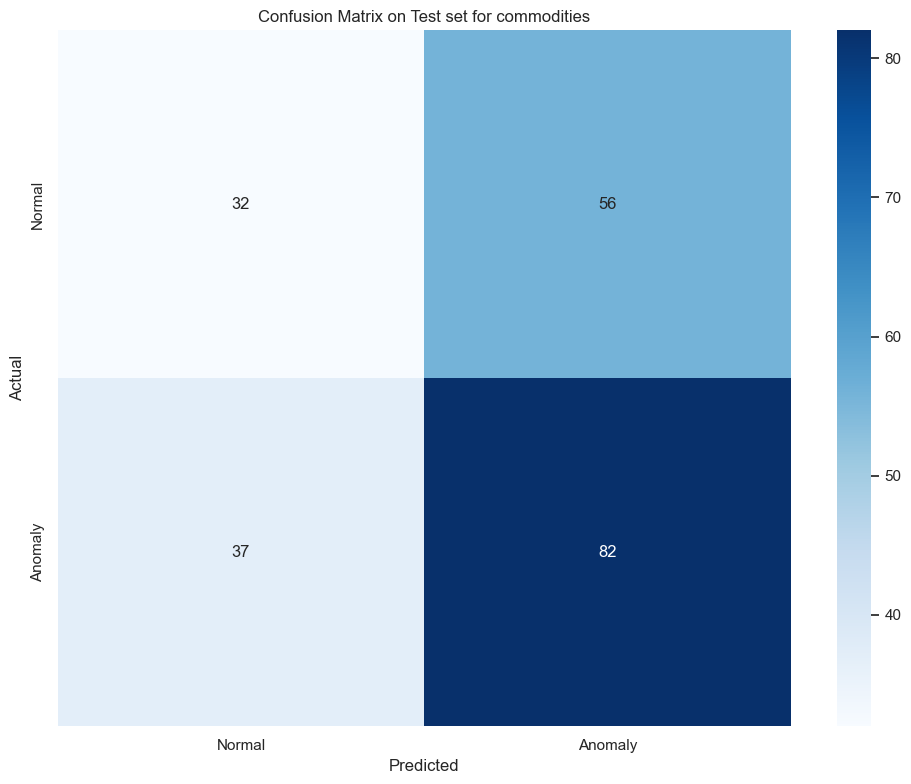


Processing group: currencies
Total examples: 1110
Normal examples: 873
Anomalous examples: 237
Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)

--- Processing currencies Group ---
Mean vector shape: (3,)
Covariance matrix shape: (3, 3)
Best Accuracy on CV set: 0.5902
Best Epsilon: 4.29360567e-02
Corresponding F1 score: 0.6471
Corresponding Precision: 0.6417
Corresponding Recall: 0.6525


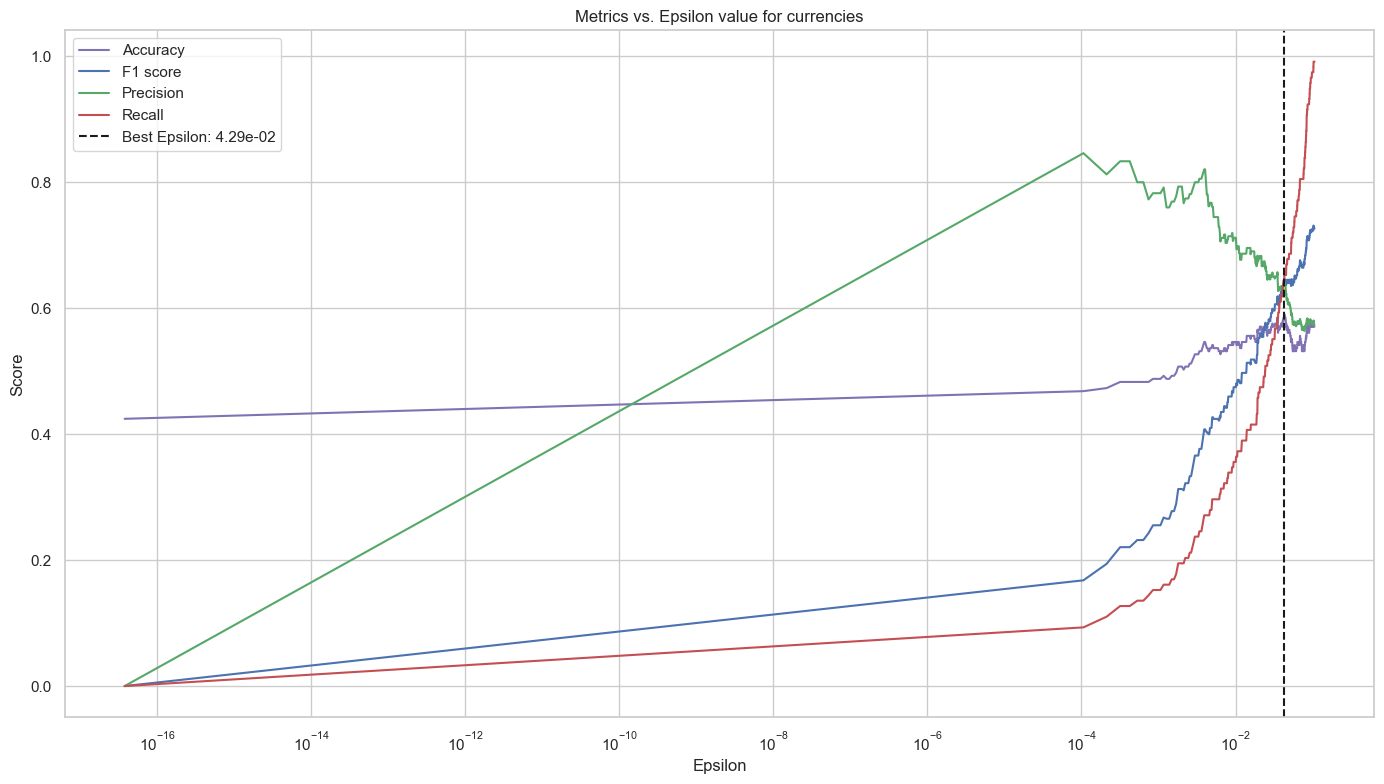


Test set performance for currencies:
Accuracy: 0.6329
Precision: 0.6693
Recall: 0.7143
F1 Score: 0.6911

Confusion Matrix:
True Negatives: 46
False Positives: 42
False Negatives: 34
True Positives: 85


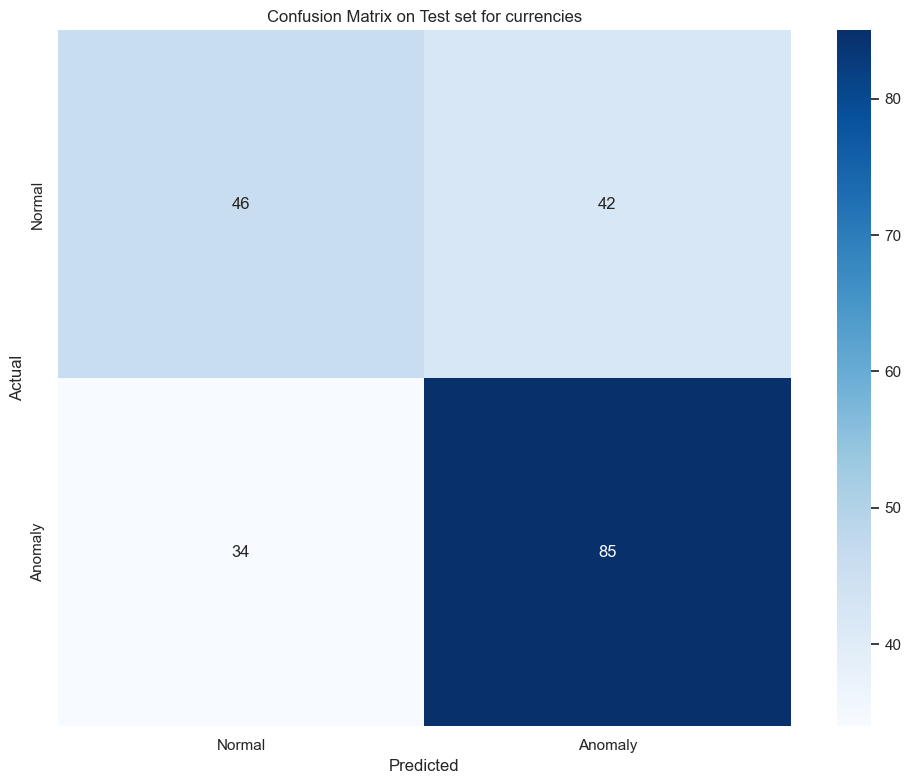


Processing group: equity_indices
Total examples: 1110
Normal examples: 873
Anomalous examples: 237
Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)

--- Processing equity_indices Group ---
Mean vector shape: (3,)
Covariance matrix shape: (3, 3)
Best Accuracy on CV set: 0.6634
Best Epsilon: 1.84546758e-02
Corresponding F1 score: 0.6933
Corresponding Precision: 0.7290
Corresponding Recall: 0.6610


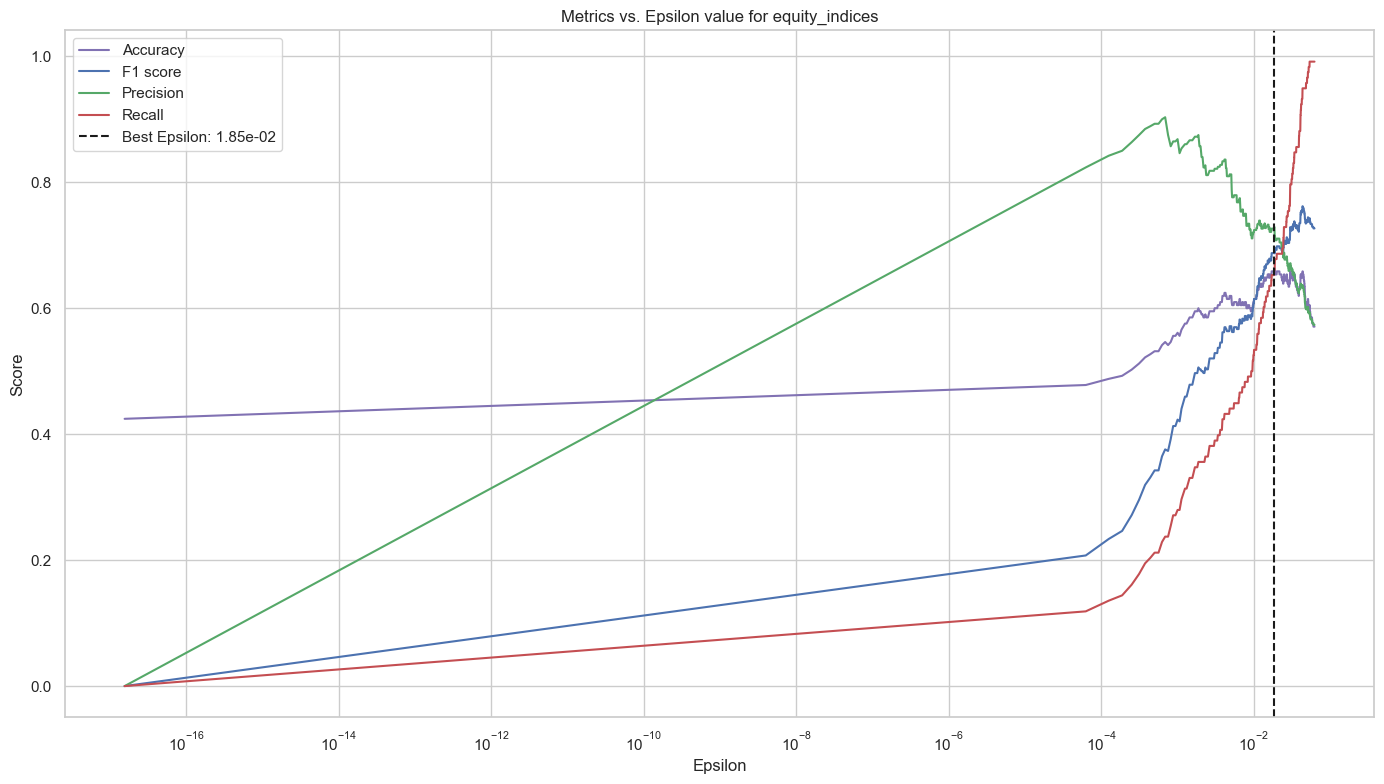


Test set performance for equity_indices:
Accuracy: 0.5942
Precision: 0.6446
Recall: 0.6555
F1 Score: 0.6500

Confusion Matrix:
True Negatives: 45
False Positives: 43
False Negatives: 41
True Positives: 78


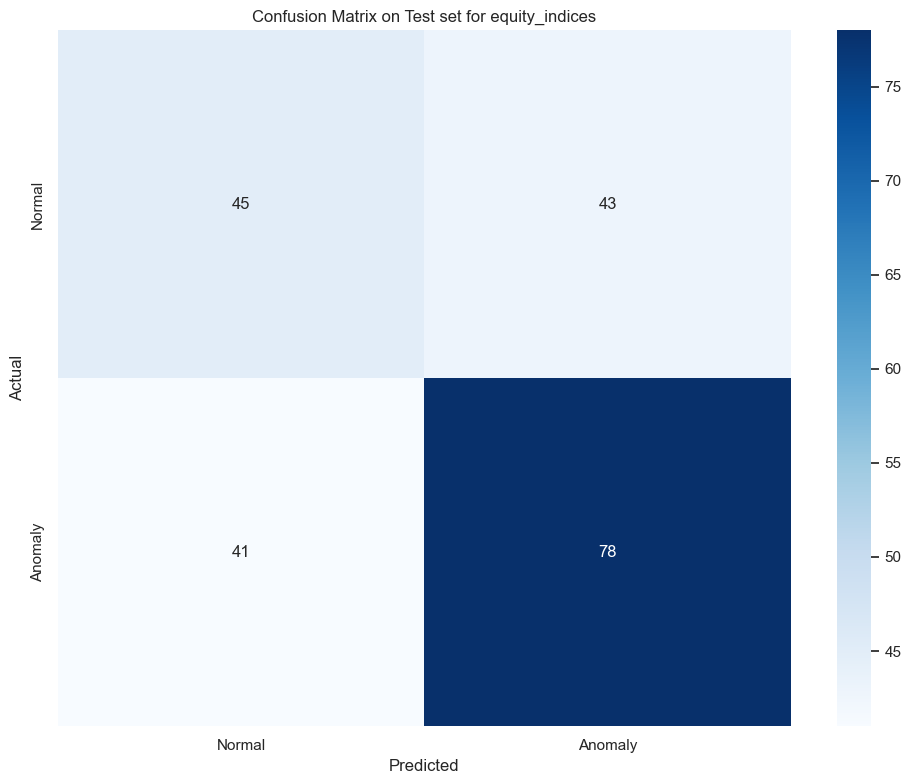


Processing group: bond_indices
Total examples: 1110
Normal examples: 873
Anomalous examples: 237
Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)

--- Processing bond_indices Group ---
Mean vector shape: (2,)
Covariance matrix shape: (2, 2)
Best Accuracy on CV set: 0.6341
Best Epsilon: 1.08733756e-01
Corresponding F1 score: 0.6862
Corresponding Precision: 0.6777
Corresponding Recall: 0.6949


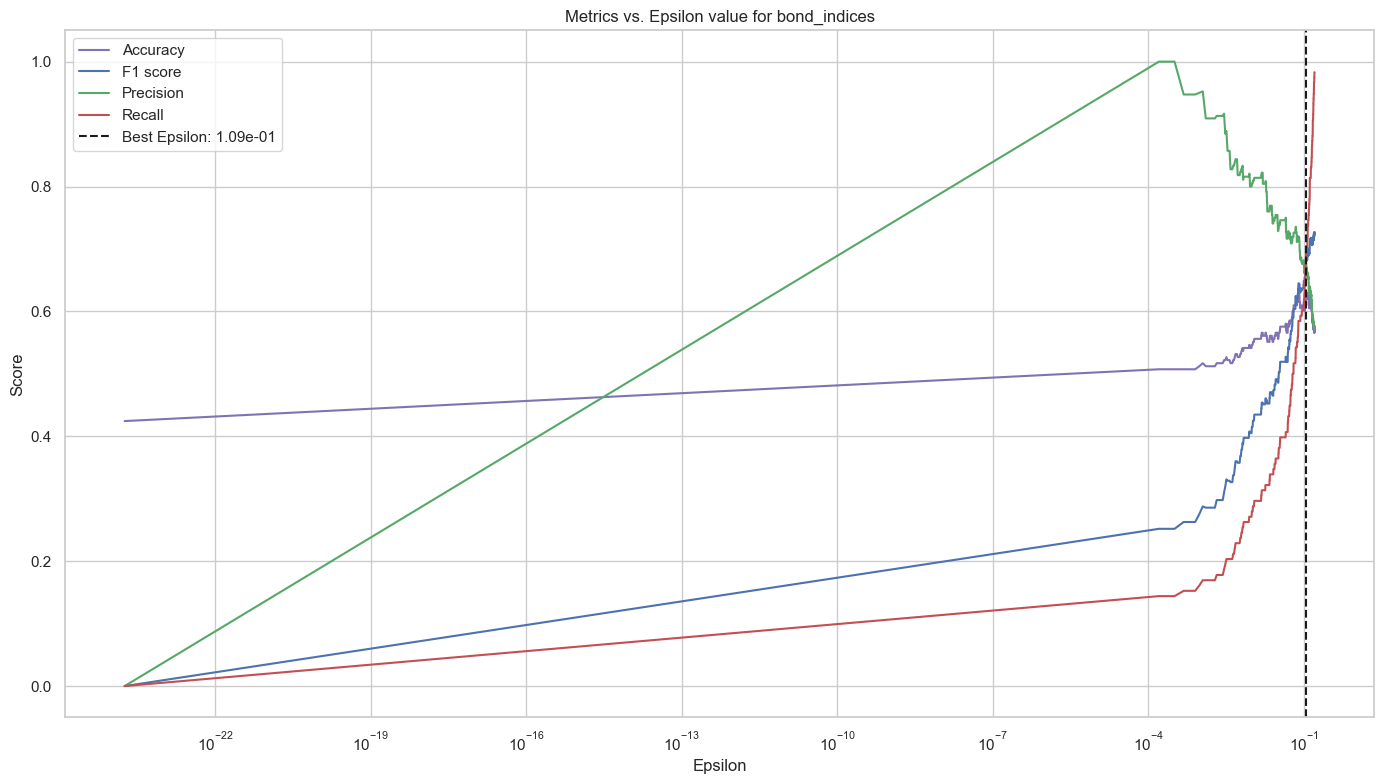


Test set performance for bond_indices:
Accuracy: 0.5942
Precision: 0.6400
Recall: 0.6723
F1 Score: 0.6557

Confusion Matrix:
True Negatives: 43
False Positives: 45
False Negatives: 39
True Positives: 80


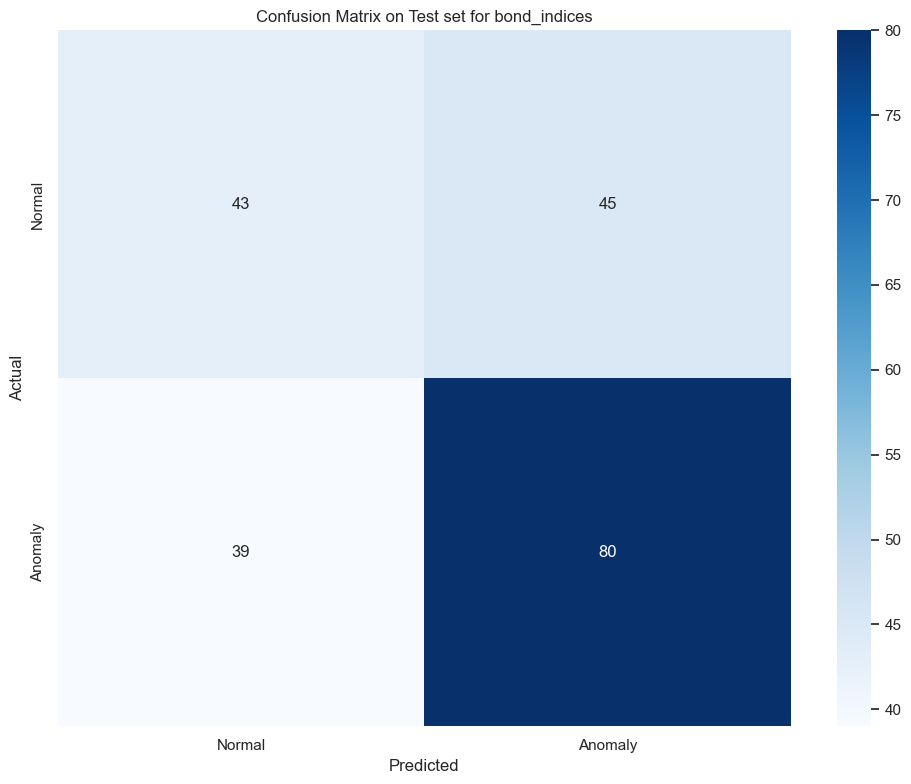


Processing group: volatility_index
Total examples: 1110
Normal examples: 873
Anomalous examples: 237
Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)

--- Processing volatility_index Group ---
Mean value: [-2.54492384e-18]
Variance value: [1.]
Best Accuracy on CV set: 0.6000
Best Epsilon: 3.96547251e-01
Corresponding F1 score: 0.7338
Corresponding Precision: 0.5947
Corresponding Recall: 0.9576


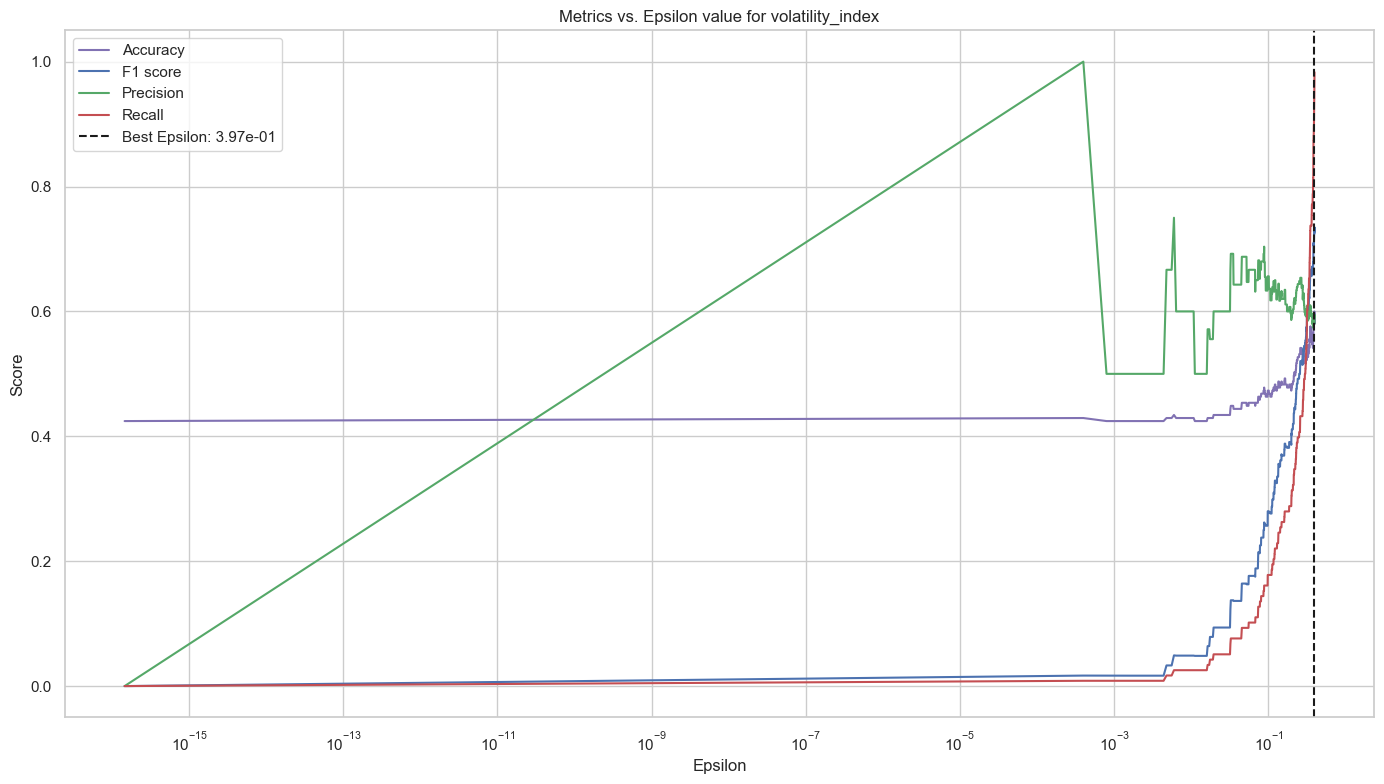


Test set performance for volatility_index:
Accuracy: 0.5700
Precision: 0.5781
Recall: 0.9328
F1 Score: 0.7138

Confusion Matrix:
True Negatives: 7
False Positives: 81
False Negatives: 8
True Positives: 111


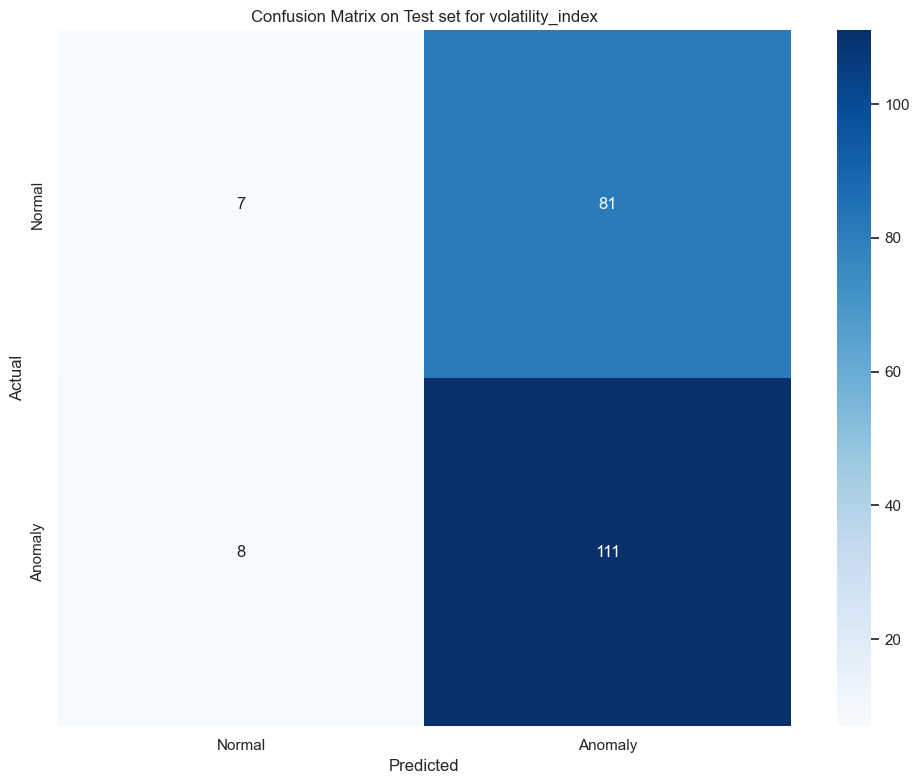


Processing group: interest_rates
Total examples: 1110
Normal examples: 873
Anomalous examples: 237
Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)

--- Processing interest_rates Group ---
Mean vector shape: (3,)
Covariance matrix shape: (3, 3)
Best Accuracy on CV set: 0.5951
Best Epsilon: 3.35370162e-02
Corresponding F1 score: 0.6498
Corresponding Precision: 0.6471
Corresponding Recall: 0.6525


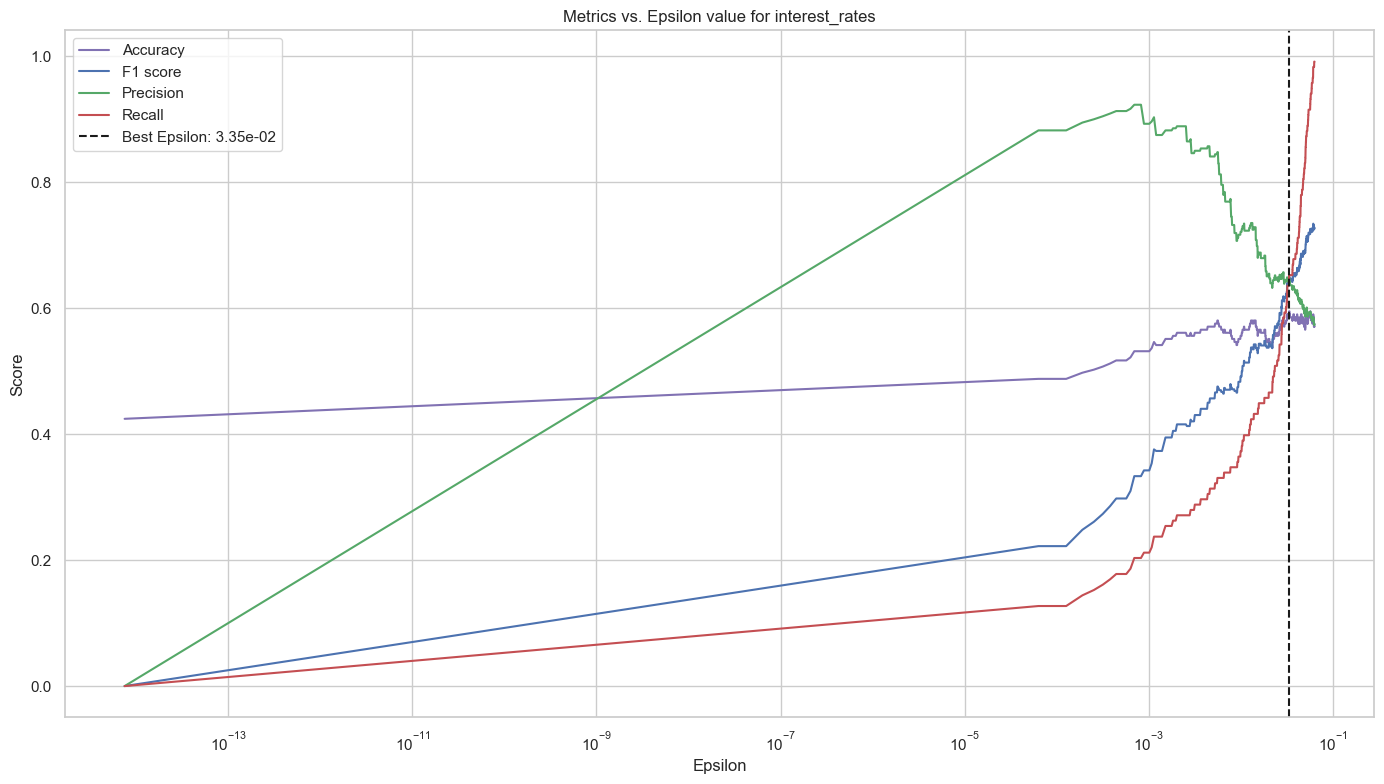


Test set performance for interest_rates:
Accuracy: 0.5990
Precision: 0.6364
Recall: 0.7059
F1 Score: 0.6693

Confusion Matrix:
True Negatives: 40
False Positives: 48
False Negatives: 35
True Positives: 84


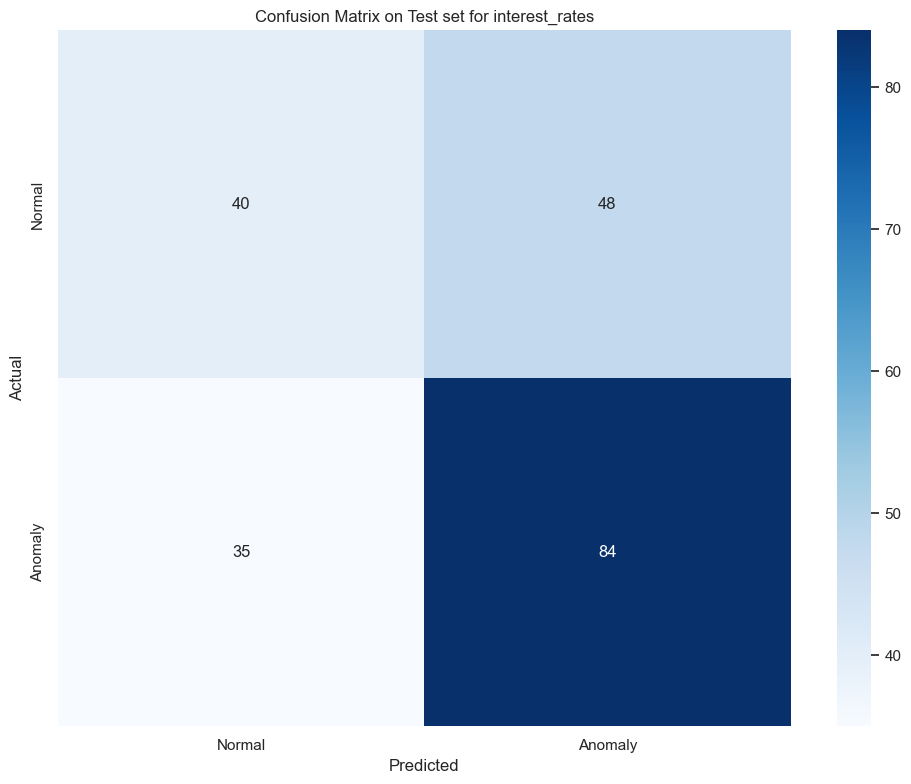


Processing group: economic_surprise
Total examples: 1110
Normal examples: 873
Anomalous examples: 237
Training set size: 698 (all normal)
Cross-validation set size: 205 (87 normal, 118 anomalies)
Test set size: 207 (88 normal, 119 anomalies)

--- Processing economic_surprise Group ---
Mean value: [-2.03593907e-17]
Variance value: [1.]
Best Accuracy on CV set: 0.5707
Best Epsilon: 3.98548091e-01
Corresponding F1 score: 0.7215
Corresponding Precision: 0.5758
Corresponding Recall: 0.9661


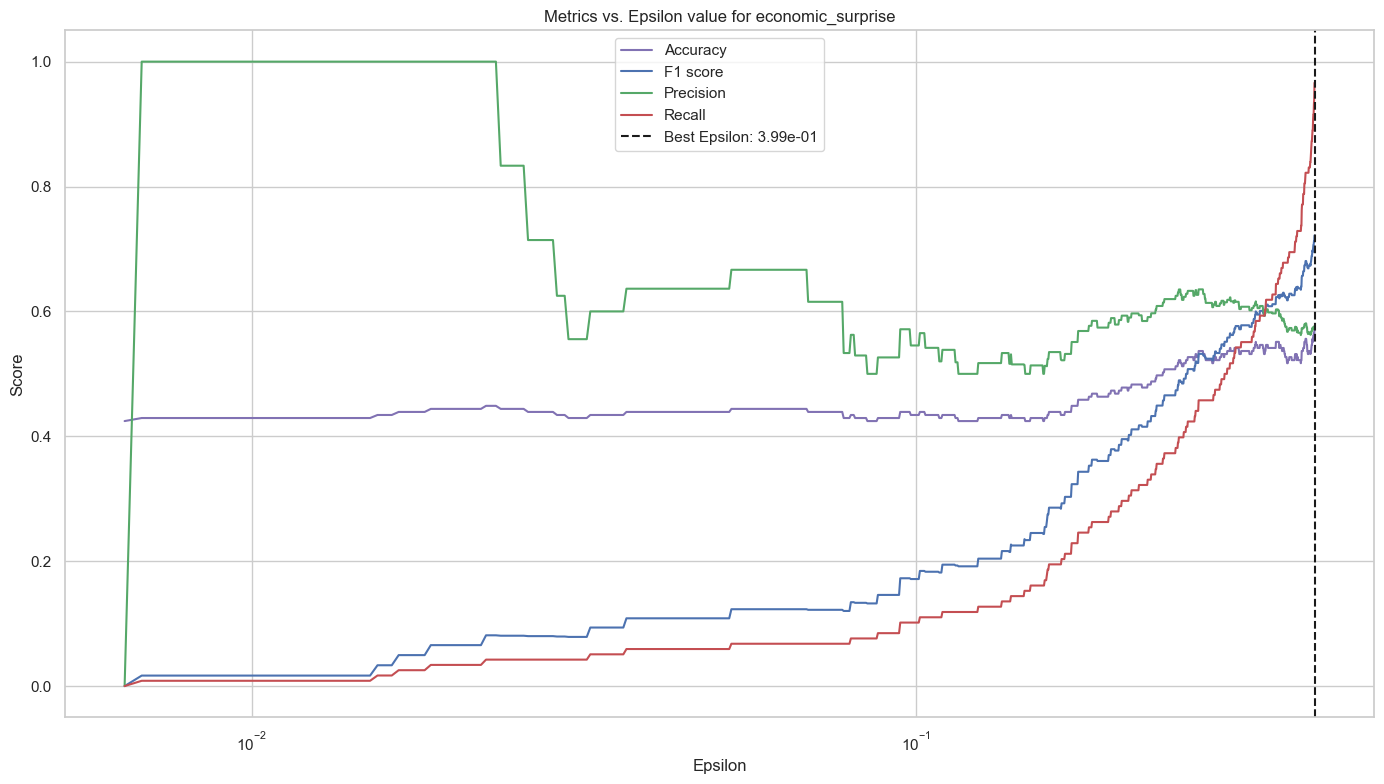


Test set performance for economic_surprise:
Accuracy: 0.5845
Precision: 0.5813
Recall: 0.9916
F1 Score: 0.7329

Confusion Matrix:
True Negatives: 3
False Positives: 85
False Negatives: 1
True Positives: 118


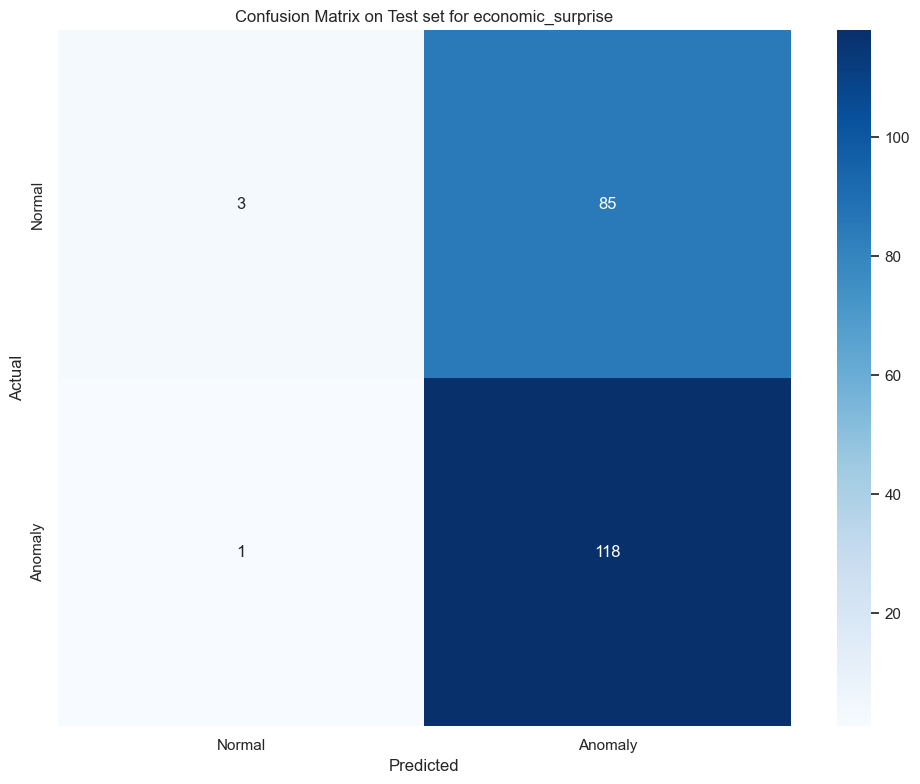



APPLYING MAJORITY VOTING FOR FINAL PREDICTIONS

Majority Voting Results:
Accuracy: 0.5990
Precision: 0.6059
Recall: 0.8655
F1 Score: 0.7128

Confusion Matrix for Majority Voting:
True Negatives: 21
False Positives: 67
False Negatives: 16
True Positives: 103


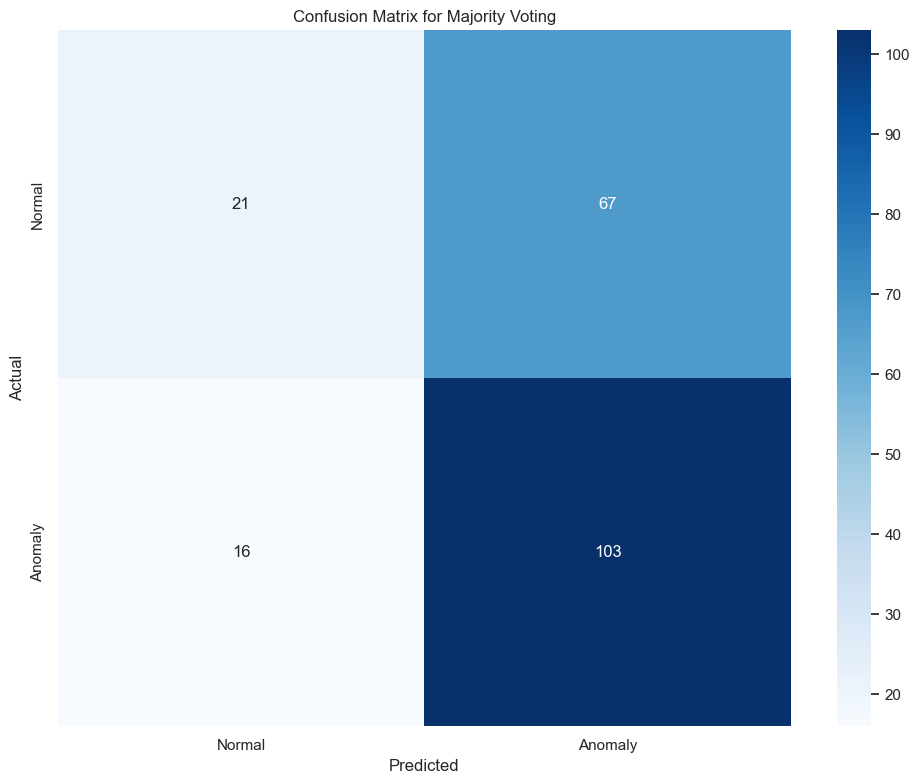



SUMMARY OF RESULTS

Performance metrics for all models:
                   Accuracy  Precision    Recall  F1 Score
commodities        0.550725   0.594203  0.689076  0.638132
currencies         0.632850   0.669291  0.714286  0.691057
equity_indices     0.594203   0.644628  0.655462  0.650000
bond_indices       0.594203   0.640000  0.672269  0.655738
volatility_index   0.570048   0.578125  0.932773  0.713826
interest_rates     0.599034   0.636364  0.705882  0.669323
economic_surprise  0.584541   0.581281  0.991597  0.732919
Majority Voting    0.599034   0.605882  0.865546  0.712803


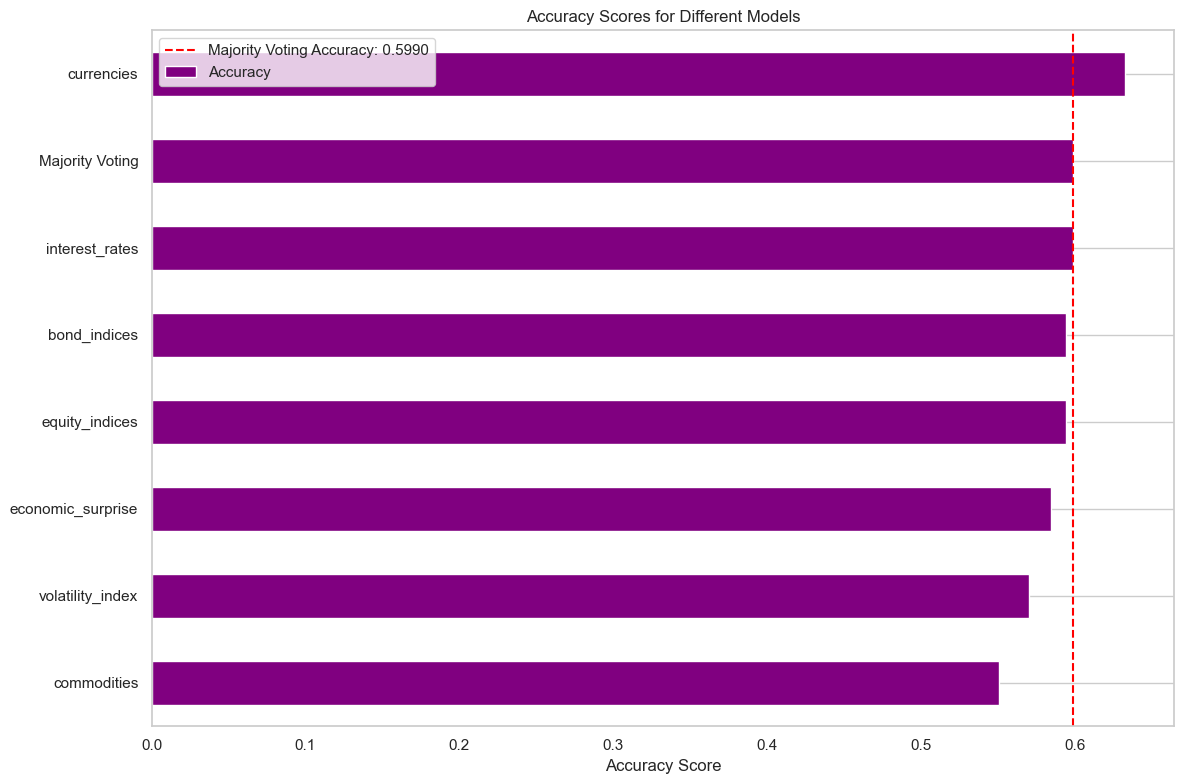

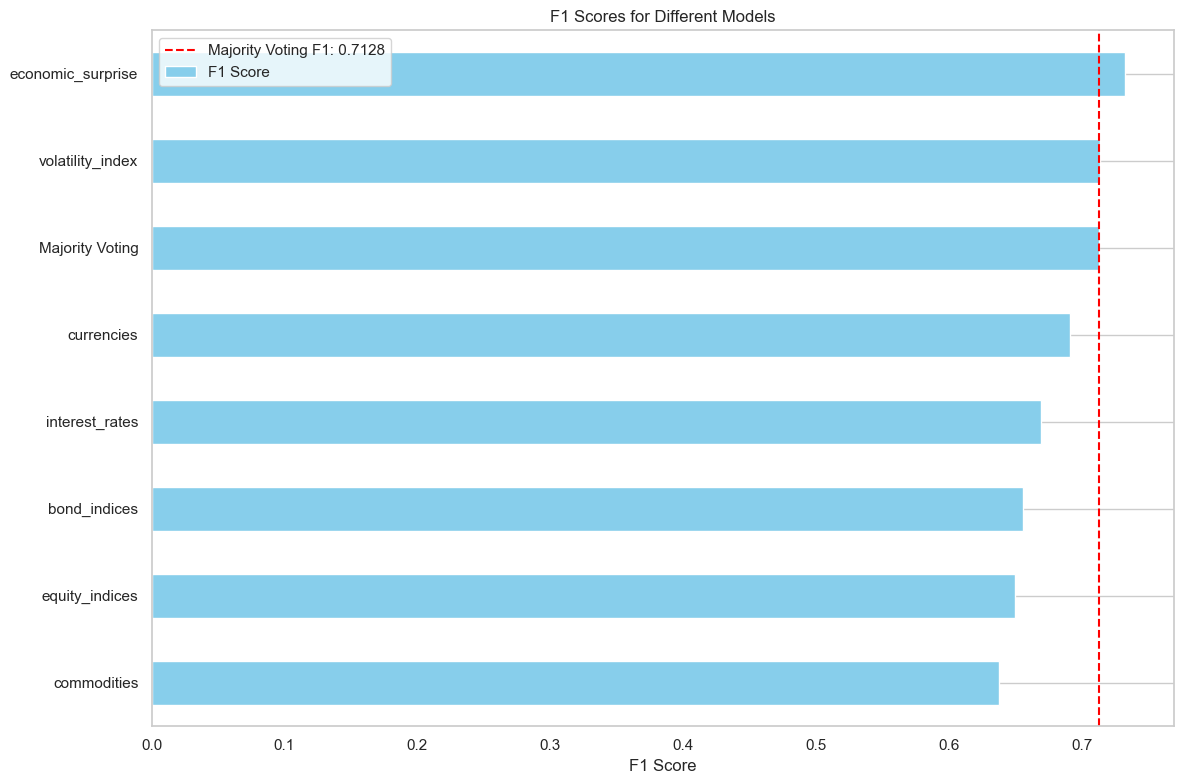

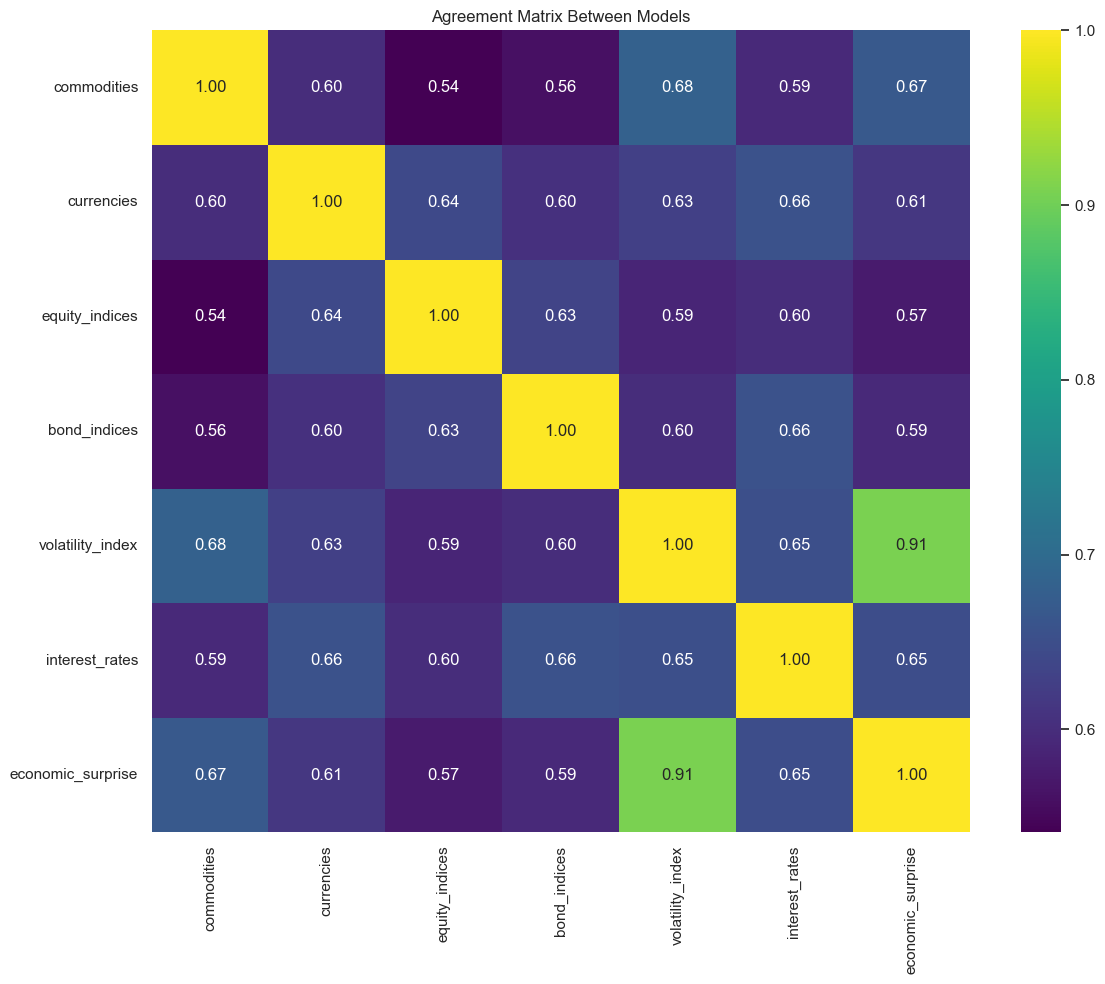

In [10]:
from sklearn.utils import shuffle

# Set visualization style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# Function to calculate Gaussian PDF (handles both univariate and multivariate cases)
def multivariate_gaussian_pdf(X, mu, sigma):
    """Calculate the Gaussian probability density function (univariate or multivariate)"""
    n = mu.shape[0]
    
    # Univariate distribution (only one feature)
    if n == 1:
        # Univariate gaussian PDF 
        variance = sigma[0]  # variance
        p = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            x_minus_mu = X[i, 0] - mu[0]
            p[i] = (1.0 / np.sqrt(2 * np.pi * variance)) * \
                   np.exp(-0.5 * (x_minus_mu**2) / variance)
        return p
    
    # standard: multivariate distribution (2+ features)
    # Handle potential numerical issues with the covariance matrix
    # Add a small regularization term to ensure positive definiteness
    else :
        sigma_reg = sigma + np.eye(n) * 1e-8

        # Calculate determinant and inverse
        try:
            det = np.linalg.det(sigma_reg)
            inv = np.linalg.inv(sigma_reg)
        except np.linalg.LinAlgError:
            # If still having issues, use pseudo-inverse
            print("Warning: Using pseudo-inverse for covariance matrix")
            det = max(np.linalg.det(sigma_reg), 1e-10)
            inv = np.linalg.pinv(sigma_reg)

        # Calculate PDF for each example
        p = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            x_mu = X[i] - mu
            p[i] = (1.0 / (np.power(2 * np.pi, n/2) * np.sqrt(det))) * \
                np.exp(-0.5 * x_mu.dot(inv).dot(x_mu))

    return p

# Function to train and evaluate multivariate Gaussian model
def train_evaluate_mvg(X_train, X_cv, y_cv, X_test, y_test, group_name):
    """Train and evaluate multivariate Gaussian model for a specific group"""
    
    print(f"\n--- Processing {group_name} Group ---")
    
    # Step 2: Training the model (estimating parameters of multivariate Gaussian)
    # Calculate mean vector
    mu = np.mean(X_train, axis=0)
    
    # Calculate covariance matrix - handle both univariate and multivariate cases
    if X_train.shape[1] == 1:
        # For univariate case, just calculate variance
        sigma = np.var(X_train, axis=0)
        print(f"Mean value: {mu}")
        print(f"Variance value: {sigma}")
    else:
        # For multivariate case, calculate full covariance matrix
        sigma = np.cov(X_train, rowvar=False)
        print(f"Mean vector shape: {mu.shape}")
        print(f"Covariance matrix shape: {sigma.shape}")
    
    # Step 3: Fine tuning the hyperparameter, the threshold ϵ
    # Compute the probability density function for the cross-validation set
    p_cv = multivariate_gaussian_pdf(X_cv, mu, sigma)
    
    # Find the range of epsilon values to search
    min_epsilon = np.min(p_cv)
    max_epsilon = np.max(p_cv)
    step_size = (max_epsilon - min_epsilon) / 1000
    
    # Find the best epsilon using Accuracy score
    best_epsilon = 0
    best_accuracy = 0
    best_precision = 0
    best_recall = 0
    best_f1 = 0
    
    epsilon_values = np.arange(min_epsilon, max_epsilon, step_size)
    accuracy_scores = []
    f1_scores = []
    precisions = []
    recalls = []
    
    for epsilon in epsilon_values:
        predictions = (p_cv < epsilon).astype(int)
        
        # Calculate metrics
        accuracy = accuracy_score(y_cv, predictions)
        precision = precision_score(y_cv, predictions, zero_division=0)
        recall = recall_score(y_cv, predictions, zero_division=0)
        
        # Calculate F1 score
        if precision + recall > 0:  # Avoid division by zero
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
        
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        precisions.append(precision)
        recalls.append(recall)
        
        # Now we optimize for accuracy instead of F1
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epsilon = epsilon
            best_precision = precision
            best_recall = recall
            best_f1 = f1
    
    print(f"Best Accuracy on CV set: {best_accuracy:.4f}")
    print(f"Best Epsilon: {best_epsilon:.8e}")
    print(f"Corresponding F1 score: {best_f1:.4f}")
    print(f"Corresponding Precision: {best_precision:.4f}")
    print(f"Corresponding Recall: {best_recall:.4f}")
    
    # Plot Accuracy, F1 score, precision, and recall vs epsilon
    plt.figure(figsize=(14, 8))
    plt.plot(epsilon_values, accuracy_scores, 'm-', label='Accuracy')
    plt.plot(epsilon_values, f1_scores, 'b-', label='F1 score')
    plt.plot(epsilon_values, precisions, 'g-', label='Precision')
    plt.plot(epsilon_values, recalls, 'r-', label='Recall')
    plt.axvline(x=best_epsilon, color='k', linestyle='--', label=f'Best Epsilon: {best_epsilon:.2e}')
    plt.xlabel('Epsilon')
    plt.ylabel('Score')
    plt.title(f'Metrics vs. Epsilon value for {group_name}')
    plt.legend()
    plt.xscale('log')  # Log scale for better visualization
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Step 4: Testing the model
    # Compute the probability density function for the test set
    p_test = multivariate_gaussian_pdf(X_test, mu, sigma)
    
    # Make predictions using the best epsilon
    predictions = (p_test < best_epsilon).astype(int)
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test, predictions)
    test_precision = precision_score(y_test, predictions, zero_division=0)
    test_recall = recall_score(y_test, predictions, zero_division=0)
    test_f1 = f1_score(y_test, predictions, zero_division=0)
    
    print(f"\nTest set performance for {group_name}:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = cm.ravel()
    
    print("\nConfusion Matrix:")
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    # Visualize confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix on Test set for {group_name}')
    plt.tight_layout()
    plt.show()
    
    return predictions, test_accuracy, test_precision, test_recall, test_f1

# Main execution 
print("Starting Multivariate Gaussian Anomaly Detection with Majority Voting\n")

# Check if y_stationary is provided
if y_stationary is None:
    raise ValueError("Response variable y_stationary is not defined")

print(f"Response variable Y shape: {y_stationary.shape}")

# Prepare data for each group, using PCA versions for equity, bond and interest rates
groups_data = {
    'commodities': stationary_data['commodities'],
    'currencies': stationary_data['currencies'],
    'equity_indices': Eq_kpca,  # Using PCA version instead of original
    'bond_indices': Bond_kpca,  # Using PCA version instead of original
    'volatility_index': stationary_data['volatility_index'],
    'interest_rates': IR_kpca,  # Using PCA version instead of original
    'economic_surprise': stationary_data['economic_surprise']
}

# Store results for all groups
all_results = {}
all_test_predictions = {}

# Process each group
for group_name, df in groups_data.items():
    print(f"\n{'='*50}\nProcessing group: {group_name}\n{'='*50}")
    
    # Convert to numpy arrays for easier manipulation
    X = df.values
    y = y_stationary
    
    # Check if X and y have compatible shapes
    if len(X) != len(y):
        print(f"Warning: X shape {X.shape} and y shape {y.shape} are incompatible for {group_name}")
        print("Skipping this group")
        continue
    
    # Step 1: Creating training/cross-validation/test set with reshuffling
    # Reshuffle the data (this will break down autocorrelation)
    X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
    
    # Separate normal and anomalous examples
    X_normal = X_shuffled[y_shuffled == 0]
    X_anomaly = X_shuffled[y_shuffled == 1]
    
    # Calculate sizes for each set
    n_normal = X_normal.shape[0]
    n_anomaly = X_anomaly.shape[0]
    
    print(f"Total examples: {len(X)}")
    print(f"Normal examples: {n_normal}")
    print(f"Anomalous examples: {n_anomaly}")
    
    # Training set: 80% of normal examples
    train_size = int(0.8 * n_normal)
    X_train = X_normal[:train_size]
    
    # Cross-validation set: 10% of normal examples and 50% of anomalies
    cv_normal_size = int(0.1 * n_normal)
    cv_anomaly_size = int(0.5 * n_anomaly)
    X_cv_normal = X_normal[train_size:train_size + cv_normal_size]
    X_cv_anomaly = X_anomaly[:cv_anomaly_size]
    X_cross_val = np.vstack((X_cv_normal, X_cv_anomaly))
    y_cross_val = np.hstack((np.zeros(cv_normal_size), np.ones(cv_anomaly_size)))
    
    # Test set: 10% of normal examples and 50% of anomalies
    X_test_normal = X_normal[train_size + cv_normal_size:]
    X_test_anomaly = X_anomaly[cv_anomaly_size:]
    X_test = np.vstack((X_test_normal, X_test_anomaly))
    y_test = np.hstack((np.zeros(len(X_test_normal)), np.ones(len(X_test_anomaly))))
    
    # We'll standardize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_cross_val = scaler.transform(X_cross_val)
    X_test = scaler.transform(X_test)
    
    print(f"Training set size: {X_train.shape[0]} (all normal)")
    print(f"Cross-validation set size: {X_cross_val.shape[0]} ({cv_normal_size} normal, {cv_anomaly_size} anomalies)")
    print(f"Test set size: {X_test.shape[0]} ({len(X_test_normal)} normal, {len(X_test_anomaly)} anomalies)")
    
    # Train and evaluate the model
    predictions, accuracy, precision, recall, f1 = train_evaluate_mvg(
        X_train, X_cross_val, y_cross_val, X_test, y_test, group_name
    )
    
    # Store the results
    all_results[group_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    all_test_predictions[group_name] = {
        'predictions': predictions,
        'y_test': y_test
    }

# Step 5: Apply majority voting on the test set predictions
print("\n\n" + "="*60)
print("APPLYING MAJORITY VOTING FOR FINAL PREDICTIONS")
print("="*60)

# Extract all test predictions and actual labels
# We need to ensure all test sets have the same examples in the same order
# For simplicity, we'll check if all y_test are identical
y_test_values = [data['y_test'] for data in all_test_predictions.values()]
all_same = all((y_test_values[0] == y_test).all() for y_test in y_test_values[1:])

if not all_same:
    print("Warning: Test sets are not identical across all groups!")
    # In a real scenario, you would need to handle this case carefully
    # For this example, we'll proceed with the assumption they're aligned

# Get a reference y_test from any group
reference_y_test = next(iter(all_test_predictions.values()))['y_test']

# Create a matrix of all predictions
all_preds = np.array([data['predictions'] for data in all_test_predictions.values()])

# Apply majority voting (more than half of the models predict anomaly)
majority_threshold = all_preds.shape[0] / 2
majority_votes = (np.sum(all_preds, axis=0) > majority_threshold).astype(int)

# Calculate metrics for the majority voting
majority_accuracy = accuracy_score(reference_y_test, majority_votes)
majority_precision = precision_score(reference_y_test, majority_votes, zero_division=0)
majority_recall = recall_score(reference_y_test, majority_votes, zero_division=0)
majority_f1 = f1_score(reference_y_test, majority_votes, zero_division=0)

print("\nMajority Voting Results:")
print(f"Accuracy: {majority_accuracy:.4f}")
print(f"Precision: {majority_precision:.4f}")
print(f"Recall: {majority_recall:.4f}")
print(f"F1 Score: {majority_f1:.4f}")

# Create confusion matrix for majority voting
cm_majority = confusion_matrix(reference_y_test, majority_votes)
tn, fp, fn, tp = cm_majority.ravel()

print("\nConfusion Matrix for Majority Voting:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_majority, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Majority Voting')
plt.tight_layout()
plt.show()

# Summary of results
print("\n\n" + "="*60)
print("SUMMARY OF RESULTS")
print("="*60)

# Create a DataFrame to display all results
results_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])

for group_name, results in all_results.items():
    results_df.loc[group_name] = [
        results['accuracy'],
        results['precision'],
        results['recall'],
        results['f1']
    ]

# Add majority voting results
results_df.loc['Majority Voting'] = [majority_accuracy, majority_precision, majority_recall, majority_f1]

# Display and plot the results
print("\nPerformance metrics for all models:")
print(results_df)

# Plot Accuracy scores
plt.figure(figsize=(12, 8))
results_df['Accuracy'].sort_values().plot(kind='barh', color='purple')
plt.axvline(x=majority_accuracy, color='red', linestyle='--', 
            label=f'Majority Voting Accuracy: {majority_accuracy:.4f}')
plt.xlabel('Accuracy Score')
plt.title('Accuracy Scores for Different Models')
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Plot F1 scores for comparison
plt.figure(figsize=(12, 8))
results_df['F1 Score'].sort_values().plot(kind='barh', color='skyblue')
plt.axvline(x=majority_f1, color='red', linestyle='--', 
            label=f'Majority Voting F1: {majority_f1:.4f}')
plt.xlabel('F1 Score')
plt.title('F1 Scores for Different Models')
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Optional: Visualize agreement between models
agreement_matrix = np.zeros((len(all_test_predictions), len(all_test_predictions)))
group_names = list(all_test_predictions.keys())

for i, group1 in enumerate(group_names):
    for j, group2 in enumerate(group_names):
        preds1 = all_test_predictions[group1]['predictions']
        preds2 = all_test_predictions[group2]['predictions']
        agreement = np.mean(preds1 == preds2)
        agreement_matrix[i, j] = agreement

# Plot the agreement matrix
plt.figure(figsize=(12, 10))
sns.heatmap(agreement_matrix, annot=True, fmt='.2f', cmap='viridis',
            xticklabels=group_names, yticklabels=group_names)
plt.title('Agreement Matrix Between Models')
plt.tight_layout()
plt.show()